# 1. Introducción

El siguiente notebook consiste en el desarrollo del proyecto final del Diplomado de Data Science de la Universidad de Santiago de Chile.

En él se buscó explorar en torno a las posibilidades de entender dinámicas socioespaciales de un territorio, particularmente la localidad de Laguna Verde. Esto en el contexto de plantear alternativas metodológicas para instancias de prefactibilidad y factibilidad realizados en el contexto de la evaluación ante solicitudes de generación de nuevas comunas por parte de la SUBDERE.

Alumno: Martín Bonnefoy

# 2. Librerías ocupadas

In [1]:
import pandas as pd
import numpy as np

# Librerías de visualización
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go


# Librerías de procesamiento de texto
import re

# Librerías de procesamiento de lenguaje
import unicodedata
import nltk
# from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('spanish')
from nltk import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Librerías de algoritmos de procesamiento de información
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.preprocessing

# Tensorflow
import tensorflow as tf

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martín\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 3. Procesamiento de datos

# 3.1. Cargado de los dataset

In [2]:
# Paths ocupados en versión Google Colab

path_metadatos = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT9lJSXXsSSEdVWekEYJGBsGycvvz-wnP0X50z_9oDaoz1PWGMSgLSDlEctbMO6sw/pub?output=xlsx'
path_visuales = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ0PY4NHOvJpuyxmso4u0cJ5cutHDIW-e4LzI7AtgdimL72U8u0G_56HjY0-sifzhbP7xv-EWOPs9bA/pub?output=csv'

# Paths ocupados en versión Local

# path_metadatos = 'output.xlsx'
# path_visuales = 'measurements.csv'

# Carga de DF

df_metadatos = pd.read_excel(path_metadatos)

df_visuales = pd.read_csv(path_visuales)

# En versión local, es necesario indicar el separador
# df_visuales = pd.read_csv(path_visuales, sep=';')

In [3]:
df_metadatos.head()

,Name,Full Path,Size,Authors,Title,Dimensions,Tags,Comments,Unnamed: 8
0,2012-10-01 23.31.01 292972465788384309_2222347...,C:\Users\Martín\Archivos\Clases\Diplomado Data...,140841.0,ivanretamal,https://www.instagram.com/p/QQ2OfISXQ1/,612 x 612,lasdocas; lasdocaschile,Camino a #lasdocas #lasdocaschile,NaN
1,2017-07-24 19.55.50 1566324167988813352_419367...,C:\Users\Martín\Archivos\Clases\Diplomado Data...,175555.0,nea_ruda,https://www.instagram.com/p/BW8tJQMFN-4/,1080 x 1080,travel; loveislove; locura; whiscky; iloveyou;...,??. . . . . #travel #loveislove #locura #whis...,NaN
2,2017-07-24 19.55.50 1566324194572259642_419367...,C:\Users\Martín\Archivos\Clases\Diplomado Data...,194106.0,nea_ruda,https://www.instagram.com/p/BW8tJQMFN-4/,1080 x 1080,travel; loveislove; locura; whiscky; iloveyou;...,??. . . . . #travel #loveislove #locura #whis...,NaN
3,2017-07-24 19.55.50 1566324222900673468_419367...,C:\Users\Martín\Archivos\Clases\Diplomado Data...,84597.0,nea_ruda,https://www.instagram.com/p/BW8tJQMFN-4/,1080 x 1080,travel; loveislove; locura; whiscky; iloveyou;...,??. . . . . #travel #loveislove #locura #whis...,NaN
4,2017-07-24 19.55.50 1566324249467417713_419367...,C:\Users\Martín\Archivos\Clases\Diplomado Data...,107197.0,nea_ruda,https://www.instagram.com/p/BW8tJQMFN-4/,1080 x 1080,travel; loveislove; locura; whiscky; iloveyou;...,??. . . . . #travel #loveislove #locura #whis...,NaN


In [4]:
df_visuales.head()

,filename,imageID,brightness_median,brightness_stdev,saturation_median,saturation_stdev,hue_median,hue_stdev
0,2012-10-01 23.31.01 292972465788384309_2222347...,1,120,476.681,44,24.932,124,810.837
1,2017-07-24 19.55.50 1566324167988813352_419367...,2,73,859.393,85,499.742,139,556.514
2,2017-07-24 19.55.50 1566324194572259642_419367...,3,28,960.022,95,599.868,147,162.366
3,2017-07-24 19.55.50 1566324222900673468_419367...,4,125,855.185,96,552.991,128,517.967
4,2017-07-24 19.55.50 1566324249467417713_419367...,5,28,879.292,137,761.828,35,757.786


# 3.2. Consolidación del dataset

In [5]:
# Se combinan ambos df

df = pd.merge(df_metadatos, df_visuales, left_on="Name", right_on='filename', how='left')

In [6]:
# Se eliminan columnas presentes en ambos df y/o sin utilidad para el análisis

df = df.drop('filename', axis=1)
df = df.drop('Unnamed: 8', axis=1)
df = df.drop('Full Path', axis=1)

In [7]:
# Se cambian los nombres de las columnas tal de identificar correctamente a qué corresponden

df = df.rename(columns={'Name' : 'Filename'})
df = df.rename(columns={'Authors' : 'User'})
df = df.rename(columns={'Title' : 'URL'})
df = df.rename(columns={'Tags' : 'Hashtags'})
df = df.rename(columns={'Comments' : 'Description'})
df = df.rename(columns={'imageID' : 'ImageID'})

In [8]:
# Reordenar orden de columnas

secuencia = ['ImageID', 'Filename', 'Size', 'URL', 'User', 'Description', 'Hashtags', 'Dimensions', 'brightness_median', 'brightness_stdev', 'saturation_median', 'saturation_stdev', 'hue_median', 'hue_stdev']

df = df.reindex(columns=secuencia)

In [9]:
df.dtypes

ImageID                int64
Filename              object
Size                 float64
URL                   object
User                  object
Description           object
Hashtags              object
Dimensions            object
brightness_median      int64
brightness_stdev      object
saturation_median      int64
saturation_stdev      object
hue_median             int64
hue_stdev             object
dtype: object

# 4. Descripción de datos iniciales

In [10]:
df.head()

,ImageID,Filename,Size,URL,User,Description,Hashtags,Dimensions,brightness_median,brightness_stdev,saturation_median,saturation_stdev,hue_median,hue_stdev
0,1,2012-10-01 23.31.01 292972465788384309_2222347...,140841.0,https://www.instagram.com/p/QQ2OfISXQ1/,ivanretamal,Camino a #lasdocas #lasdocaschile,lasdocas; lasdocaschile,612 x 612,120,476.681,44,24.932,124,810.837
1,2,2017-07-24 19.55.50 1566324167988813352_419367...,175555.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,73,859.393,85,499.742,139,556.514
2,3,2017-07-24 19.55.50 1566324194572259642_419367...,194106.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,28,960.022,95,599.868,147,162.366
3,4,2017-07-24 19.55.50 1566324222900673468_419367...,84597.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,125,855.185,96,552.991,128,517.967
4,5,2017-07-24 19.55.50 1566324249467417713_419367...,107197.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,28,879.292,137,761.828,35,757.786


In [11]:
variables_categoricas = ['Filename', 'URL', 'User', 'Description', 'Hashtags', 'Dimensions', 'brightness_stdev', 'saturation_stdev', 'hue_stdev']

variables_numericas = ['ImageID', 'Size', 'brightness_median', 'saturation_median','hue_median']

In [12]:
print(f"Descripción de variables categóricas:\n")

for variable in variables_categoricas:

  if variable != 'Hashtags' and variable != 'Description': # Ya que hay publicaciones sin descripción ni hashtag, se filtra
    print(f'''Variable [{variable}]
    Tipo de dato: {type(df[variable][0])}
    Ejemplo: {df[variable].loc[0]}
    Cantidad de valores únicos: {len(df[variable].unique())}
    Cantidad de valores perdidos: {df[variable].isna().sum()}
    Porcentaje de valores perdidos: {((df[variable].isna().sum() * 100 ) / len(df[variable]))}
    ''')

  else:
    print(f'''Variable [{variable}]
    Tipo de dato: {type(df[variable][0])}
    Ejemplo: {df[variable].loc[0]}
    Cantidad de valores únicos: {len(df[variable].unique())}
    ''')

Descripción de variables categóricas:

Variable [Filename]
    Tipo de dato: <class 'str'>
    Ejemplo: 2012-10-01 23.31.01 292972465788384309_222234700.jpg
    Cantidad de valores únicos: 34771
    Cantidad de valores perdidos: 0
    Porcentaje de valores perdidos: 0.0
    
Variable [URL]
    Tipo de dato: <class 'str'>
    Ejemplo: https://www.instagram.com/p/QQ2OfISXQ1/
    Cantidad de valores únicos: 14611
    Cantidad de valores perdidos: 7
    Porcentaje de valores perdidos: 0.0201317189612033
    
Variable [User]
    Tipo de dato: <class 'str'>
    Ejemplo: ivanretamal
    Cantidad de valores únicos: 5361
    Cantidad de valores perdidos: 7
    Porcentaje de valores perdidos: 0.0201317189612033
    
Variable [Description]
    Tipo de dato: <class 'str'>
    Ejemplo: Camino a #lasdocas  #lasdocaschile
    Cantidad de valores únicos: 12005
    
Variable [Hashtags]
    Tipo de dato: <class 'str'>
    Ejemplo: lasdocas; lasdocaschile
    Cantidad de valores únicos: 4816
    
Variabl

In [13]:
print(f"Descripción de variables numéricas:\n")

variables_numericas

for variable in variables_numericas:
  print(f'''Variable [{variable}]
  Tipo de dato: {type(df[variable][0])}
  Valor Mínimo: {df[variable].min()}
  Valor Máximo: {df[variable].max()}
  Ejemplo: {df[variable].loc[0]}
  Cantidad de valores únicos: {len(df[variable].unique())}
  Cantidad de valores perdidos: {df[variable].isna().sum()}
  Porcentaje de valores perdidos: {((df[variable].isna().sum() * 100 ) / len(df[variable]))}
  ''')


Descripción de variables numéricas:

Variable [ImageID]
  Tipo de dato: <class 'numpy.int64'>
  Valor Mínimo: 1
  Valor Máximo: 34771
  Ejemplo: 1
  Cantidad de valores únicos: 34455
  Cantidad de valores perdidos: 0
  Porcentaje de valores perdidos: 0.0
  
Variable [Size]
  Tipo de dato: <class 'numpy.float64'>
  Valor Mínimo: 9875.0
  Valor Máximo: 1949995.0
  Ejemplo: 140841.0
  Cantidad de valores únicos: 32660
  Cantidad de valores perdidos: 0
  Porcentaje de valores perdidos: 0.0
  
Variable [brightness_median]
  Tipo de dato: <class 'numpy.int64'>
  Valor Mínimo: 0
  Valor Máximo: 255
  Ejemplo: 120
  Cantidad de valores únicos: 256
  Cantidad de valores perdidos: 0
  Porcentaje de valores perdidos: 0.0
  
Variable [saturation_median]
  Tipo de dato: <class 'numpy.int64'>
  Valor Mínimo: 0
  Valor Máximo: 255
  Ejemplo: 44
  Cantidad de valores únicos: 256
  Cantidad de valores perdidos: 0
  Porcentaje de valores perdidos: 0.0
  
Variable [hue_median]
  Tipo de dato: <class 'num

# 5. Exploración de datos iniciales

In [14]:
# fig = px.box(df,
#              x="ImageID",
#              points="all",
#              width=800,
#              height=400
#              )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.7
#     )

# fig.update_layout(
#     title={'text':'Distribución de ImageID',
#            'x':0.5
#            },
#     xaxis_title="ImageID",
#     )

# fig.show()

In [15]:
# favoritos = pd.DataFrame(df_productos.groupby('Description')['Quantity'].sum()).reset_index().sort_values('Quantity', ascending=False)

# Visualización de usuarios/as con mayor cantidad de imágenes compartidas

users_cantidadposts = pd.DataFrame(df.groupby('User')['ImageID'].count()).reset_index().sort_values('ImageID', ascending=False)

users_cantidadposts.head(20)

,User,ImageID
5113,verde_sazon,1650
2080,fundacionheuristica,1100
3189,lovelynailsgb,685
1055,celestesaborartesanal,671
85,__manu_lv__,656
2845,karma_y_yo_tenenos_un_trato,394
4270,productos_de_belleza_cassidi,329
3664,monin_lv,274
303,agro_y_suculentas,271
1133,ciclistica.litoral,238


In [16]:
# fig = px.box(users_cantidadposts,
#              x="ImageID",
#              points="all",
#              width=800,
#              height=400
#              )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.7
#     )

# fig.update_layout(
#     title={'text':'Distribución de User según cantidad de imágenes subidas',
#            'x':0.5
#            },
#     xaxis_title="User",
#     )

# fig.show()

In [17]:
# fig = px.box(df,
#              x="Size",
#              points="all",
#              width=800,
#              height=400
#              )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.7
#     )

# fig.update_layout(
#     title={'text':'Distribución de Size',
#            'x':0.5
#            },
#     xaxis_title="Size",
#     )

# fig.show()

In [18]:
hashtags_unicos = pd.DataFrame(df.groupby('Hashtags')['ImageID'].count()).reset_index().sort_values('ImageID', ascending=False)

hashtags_unicos.head(20)

,Hashtags,ImageID
1005,celestesaborartesanal; lagunaverde,300
1003,celestesaborartesanal,110
2307,lagunaverde,78
1627,estampados; skull; serigrafia; dark; darkart; ...,64
1092,chile; trekking; valparaiso,54
2561,lagunaverdevalparaiso,52
1094,chile; valparaiso,35
1225,cotizatumantenimientoconestabuenagente,35
2332,lagunaverde; celestesaborartesanal,34
805,bomberos; Onemi; Nacional; Emergencia; 5taregi...,33


In [19]:
# fig = px.box(hashtags_unicos,
#              x="ImageID",
#              points="all",
#              width=800,
#              height=400
#              )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.7
#     )

# fig.update_layout(
#     title={'text':'Distribución de Hashtags',
#            'x':0.5
#            },
#     xaxis_title="Hashtags",
#     )

# fig.show()

In [20]:
dimensiones_unicas = pd.DataFrame(df.groupby('Dimensions')['Filename'].count()).reset_index().sort_values('Filename', ascending=False)

dimensiones_unicas.head(20)

,Dimensions,Filename
246,1080 x 1080,10189
1169,1440 x 1440,4964
1369,1440 x 1800,3079
425,1080 x 1350,2128
2011,720 x 720,902
549,1080 x 810,684
1599,500 x 500,607
2634,960 x 960,549
1040,1440 x 1080,540
2056,720 x 900,409


In [21]:
# fig = px.box(dimensiones_unicas,
#              x="Filename",
#              points="all",
#              width=800,
#              height=400
#              )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.7
#     )

# fig.update_layout(
#     title={'text':'Distribución de Dimensions',
#            'x':0.5
#            },
#     xaxis_title="Dimensions",
#     )

# fig.show()

In [22]:
# Determinar nulos

df_nulos = df.copy()

In [23]:
# Se genera una función que permite separar valores nulos de no nulos, asignándoles un atributo

def Es_Nulo(x):
  if x != x:
    return 'Nulo'
  else:
    return 'No Nulo'

In [24]:
df_nulos['Description_nulo'] = df_nulos['Description'].apply(lambda x: Es_Nulo(x))

description_nulo = pd.DataFrame(df_nulos.groupby('Description_nulo')['ImageID'].count()).reset_index()

description_nulo

,Description_nulo,ImageID
0,No Nulo,32279
1,Nulo,2492


In [25]:
df_nulos['Hashtags_nulo'] = df_nulos['Hashtags'].apply(lambda x: Es_Nulo(x))

hashtags_nulo = pd.DataFrame(df_nulos.groupby('Hashtags_nulo')['ImageID'].count()).reset_index()

hashtags_nulo

,Hashtags_nulo,ImageID
0,No Nulo,13874
1,Nulo,20897


In [26]:
# Se define una función para asignar colores a los nulos/no nulos, lo que se ocupará para visualizaciones

def Color(x):
  if x == 'Nulo':
    return 'rgb(28,82,118)'
  elif x == 'No Nulo':
    return 'rgb(73,169,171)'

In [27]:
description_nulo['Color'] = description_nulo['Description_nulo'].apply(lambda x: Color(x))
hashtags_nulo['Color'] = hashtags_nulo['Hashtags_nulo'].apply(lambda x: Color(x))

In [28]:
description_nulo

,Description_nulo,ImageID,Color
0,No Nulo,32279,"rgb(73,169,171)"
1,Nulo,2492,"rgb(28,82,118)"


In [29]:
hashtags_nulo

,Hashtags_nulo,ImageID,Color
0,No Nulo,13874,"rgb(73,169,171)"
1,Nulo,20897,"rgb(28,82,118)"


In [30]:
# fig = px.bar(
#     description_nulo,
#     x='Description_nulo',
#     y='ImageID',
#     labels={'Description_nulo':'Description', 'ImageID':'Cantidad'},
#     color_discrete_sequence=description_nulo['Color'].unique(),
#     width=500,
#     height=600,
#     color='Description_nulo'
# )

# fig.update_layout(
#     title={'text':'Description - Cantidad de nulos',
#            'x':0.5
#            }
#     )

# fig.show()

In [31]:
# fig = px.bar(
#     hashtags_nulo,
#     x='Hashtags_nulo',
#     y='ImageID',
#     labels={'Hashtags_nulo':'Hashtags', 'ImageID':'Cantidad'},
#     color_discrete_sequence=description_nulo['Color'].unique(),
#     width=500,
#     height=600,
#     color='Hashtags_nulo'
# )

# fig.update_layout(
#     title={'text':'Hashtags - Cantidad de nulos',
#            'x':0.5
#            }
#     )

# fig.show()

In [32]:
# fig = px.box(df,
#              x="brightness_median",
#              points="all",
#              width=800,
#              height=400
#              )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.7
#     )

# fig.update_layout(
#     title={'text':'Distribución de Size',
#            'x':0.5
#            },
#     xaxis_title="Size",
#     )

# fig.show()

In [33]:
df_visuales_median = df[['brightness_median', 'saturation_median', 'hue_median']]

df_visuales_median.head(10)

,brightness_median,saturation_median,hue_median
0,120,44,124
1,73,85,139
2,28,95,147
3,125,96,128
4,28,137,35
5,36,136,159
6,187,89,119
7,121,66,131
8,164,52,62
9,46,69,42


In [34]:
# fig = go.Figure()

# fig.add_trace(go.Box(
#     y=df_visuales_median['brightness_median'],
#     name="brightness_median",
#     boxpoints='outliers',
#     marker_color='rgb(28,82,171)',
#     line_color='rgb(28,82,171)'
# ))

# fig.add_trace(go.Box(
#     y=df_visuales_median['saturation_median'],
#     name="saturation_median",
#     boxpoints='outliers',
#     marker_color='rgb(73,169,171)',
#     line_color='rgb(73,169,171)'
# ))

# fig.add_trace(go.Box(
#     y=df_visuales_median['hue_median'],
#     name="hue_median",
#     boxpoints='outliers',
#     marker_color='rgb(25,180,125)',
#     line_color='rgb(25,180,125)'
# ))

# fig.update_layout(
#     autosize=False,
#     width=600,
#     height=800,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
# )

# fig.update_layout(showlegend=False)

# fig.update_layout(
#     title={'text':'Distribución de Medianas',
#            'x':0.5
#            },
#     )

# fig.show()

In [35]:
df.head()

,ImageID,Filename,Size,URL,User,Description,Hashtags,Dimensions,brightness_median,brightness_stdev,saturation_median,saturation_stdev,hue_median,hue_stdev
0,1,2012-10-01 23.31.01 292972465788384309_2222347...,140841.0,https://www.instagram.com/p/QQ2OfISXQ1/,ivanretamal,Camino a #lasdocas #lasdocaschile,lasdocas; lasdocaschile,612 x 612,120,476.681,44,24.932,124,810.837
1,2,2017-07-24 19.55.50 1566324167988813352_419367...,175555.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,73,859.393,85,499.742,139,556.514
2,3,2017-07-24 19.55.50 1566324194572259642_419367...,194106.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,28,960.022,95,599.868,147,162.366
3,4,2017-07-24 19.55.50 1566324222900673468_419367...,84597.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,125,855.185,96,552.991,128,517.967
4,5,2017-07-24 19.55.50 1566324249467417713_419367...,107197.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,28,879.292,137,761.828,35,757.786


In [36]:
df_visuales_stdev = df[['brightness_stdev', 'saturation_stdev', 'hue_stdev']]

df_visuales_stdev.head(10)

,brightness_stdev,saturation_stdev,hue_stdev
0,476.681,24.932,810.837
1,859.393,499.742,556.514
2,960.022,599.868,162.366
3,855.185,552.991,517.967
4,879.292,761.828,757.786
5,585.024,574.022,558.721
6,737.143,506.458,514.079
7,643.082,554.783,516.604
8,770.429,591.168,566.704
9,528.898,423.551,28.433


In [37]:
# fig = go.Figure()

# fig.add_trace(go.Box(
#     y=df_visuales_stdev['brightness_stdev'],
#     name="brightness_stdev",
#     boxpoints='outliers',
#     marker_color='rgb(28,82,171)',
#     line_color='rgb(28,82,171)'
# ))

# fig.add_trace(go.Box(
#     y=df_visuales_stdev['saturation_stdev'],
#     name="saturation_stdev",
#     boxpoints='outliers',
#     marker_color='rgb(73,169,171)',
#     line_color='rgb(73,169,171)'
# ))

# fig.add_trace(go.Box(
#     y=df_visuales_stdev['hue_stdev'],
#     name="hue_stdev",
#     boxpoints='outliers',
#     marker_color='rgb(25,180,125)',
#     line_color='rgb(25,180,125)'
# ))

# fig.update_layout(
#     autosize=False,
#     width=600,
#     height=800,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
# )

# fig.update_layout(showlegend=False)

# fig.update_layout(
#     title={'text':'Distribución de Desviaciones Estandar',
#            'x':0.5
#            },
#     )

# fig.show()

# 6. Limpieza y Construcción

# 6.1. Tratamiento de nulos

In [38]:
df.head()

,ImageID,Filename,Size,URL,User,Description,Hashtags,Dimensions,brightness_median,brightness_stdev,saturation_median,saturation_stdev,hue_median,hue_stdev
0,1,2012-10-01 23.31.01 292972465788384309_2222347...,140841.0,https://www.instagram.com/p/QQ2OfISXQ1/,ivanretamal,Camino a #lasdocas #lasdocaschile,lasdocas; lasdocaschile,612 x 612,120,476.681,44,24.932,124,810.837
1,2,2017-07-24 19.55.50 1566324167988813352_419367...,175555.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,73,859.393,85,499.742,139,556.514
2,3,2017-07-24 19.55.50 1566324194572259642_419367...,194106.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,28,960.022,95,599.868,147,162.366
3,4,2017-07-24 19.55.50 1566324222900673468_419367...,84597.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,125,855.185,96,552.991,128,517.967
4,5,2017-07-24 19.55.50 1566324249467417713_419367...,107197.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,travel; loveislove; locura; whiscky; iloveyou;...,1080 x 1080,28,879.292,137,761.828,35,757.786


In [39]:
# Detección de valores nulos

df.isnull().sum()

ImageID                  0
Filename                 0
Size                     0
URL                      7
User                     7
Description           2492
Hashtags             20897
Dimensions               0
brightness_median        0
brightness_stdev         0
saturation_median        0
saturation_stdev         0
hue_median               0
hue_stdev                0
dtype: int64

In [40]:
df[df['User'].isna()]

,ImageID,Filename,Size,URL,User,Description,Hashtags,Dimensions,brightness_median,brightness_stdev,saturation_median,saturation_stdev,hue_median,hue_stdev
9340,9341,2021-06-25 17.24.23 2604127940047036089_812111...,68772.0,NaN,NaN,NaN,NaN,958 x 958,198,416.969,16,769.564,45,567.887
11492,11493,2021-07-28 21.18.07 2628163174874265596_100099...,52729.0,NaN,NaN,NaN,NaN,1080 x 1080,92,80.138,87,433.802,15,624.306
12607,12608,2021-08-16 08.51.59 2641558376188665192_255692...,162508.0,NaN,NaN,NaN,NaN,1080 x 810,222,670.652,167,878.386,127,924.924
15666,15667,2021-10-09 12.46.26 2680784069107581493_403811...,162254.0,NaN,NaN,NaN,NaN,1080 x 1080,158,654.258,79,514.731,44,549.984
24069,24070,2022-02-22 18.45.31 2779534306470495416_136026...,180306.0,NaN,NaN,NaN,NaN,945 x 945,177,640.233,103,480.928,132,726.277
24853,24854,2022-03-10 11.20.36 2790906782459480977_716125...,193697.0,NaN,NaN,NaN,NaN,1317 x 1317,227,671.263,49,376.144,20,57.416
25583,25584,2022-03-27 13.51.07 2803303720941067315_118570...,101803.0,NaN,NaN,NaN,NaN,1080 x 1080,90,635.154,56,374.788,23,862.079


Se detectaron 7 casos en los que no se guardaron correctamente los metadatos en los archivos. Se decide borrar estas filas y también borrar los archivos de imagen correlativos.

In [41]:
# Obtener la lista de archivos para ser borrados

nulos = ['9340', '11492', '12607', '15666', '24069', '24853', '25583']

nulos = [9340, 11492, 12607, 15666, 24069, 24853, 25583]

borrar_archivos = []

nulos

[9340, 11492, 12607, 15666, 24069, 24853, 25583]

In [42]:
for i in nulos:
    borrar_archivos.append(df.loc[i, 'Filename'])
    
for i in borrar_archivos:
    print("Borrar archivo:",i)

Borrar archivo: 2021-06-25 17.24.23 2604127940047036089_8121111627.jpg
Borrar archivo: 2021-07-28 21.18.07 2628163174874265596_10009967815.jpg
Borrar archivo: 2021-08-16 08.51.59 2641558376188665192_25569231346.jpg
Borrar archivo: 2021-10-09 12.46.26 2680784069107581493_4038118807.jpg
Borrar archivo: 2022-02-22 18.45.31 2779534306470495416_1360264757.jpg
Borrar archivo: 2022-03-10 11.20.36 2790906782459480977_7161250259.jpg
Borrar archivo: 2022-03-27 13.51.07 2803303720941067315_11857052694.jpg


In [43]:
# Borrar las filas con nulos

df = df.dropna(subset=['User'])

In [44]:
df.isnull().sum()

ImageID                  0
Filename                 0
Size                     0
URL                      0
User                     0
Description           2485
Hashtags             20890
Dimensions               0
brightness_median        0
brightness_stdev         0
saturation_median        0
saturation_stdev         0
hue_median               0
hue_stdev                0
dtype: int64

# 6.2. Extracción de fechas

In [45]:
# Extracción de fecha desde Filename

df['Date'] = ( df['Filename'].str.split(' ').str[0] + ' ' + df['Filename'].str.split(' ').str[1])

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H.%M.%S')

In [46]:
# Generación de columnas para operar sobre año, año-mes, día de la semana, hora

df['Date_Year'] = pd.DatetimeIndex(df['Date']).year

df['Date_YearMonth'] = pd.to_datetime(df['Date']).dt.to_period('M')
df['Date_YearMonth'] = df['Date_YearMonth'].astype(str)

df['Date_Hour'] = pd.DatetimeIndex(df['Date']).hour

df['Date_DOW'] = df['Date'].dt.dayofweek+1


# 6.3. Transformación de Hashtags

In [47]:
print(df['Hashtags'][0])

lasdocas; lasdocaschile


In [48]:
# Eliminar los espacios en la separación entre Tags

df['Hashtags'] = df['Hashtags'].str.replace(r' ', r'')

In [49]:
print(df['Hashtags'][0])

lasdocas;lasdocaschile


In [50]:
# Convertir hashtags en listas

df = df.assign(Hashtags = df.Hashtags.str.strip('[]').str.split(';'))

In [51]:
df['Hashtags'].head()

0                            [lasdocas, lasdocaschile]
1    [travel, loveislove, locura, whiscky, iloveyou...
2    [travel, loveislove, locura, whiscky, iloveyou...
3    [travel, loveislove, locura, whiscky, iloveyou...
4    [travel, loveislove, locura, whiscky, iloveyou...
Name: Hashtags, dtype: object

In [52]:
# Convertir listas de Hashtags en tuplas para poder iterar sobre ellas
# Se agrega un except para omitir errores por valores nulos

for index, row in df.iterrows():
  try:
    df['Hashtags'][index] = tuple(df['Hashtags'][index])
  except:
    pass

C:\Users\Martín\AppData\Local\Temp\ipykernel_8380\4227532084.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hashtags'][index] = tuple(df['Hashtags'][index])


In [53]:
for i in range(0,21):
  if df.loc[i, 'Hashtags'] == df.loc[i, 'Hashtags']:
    print(f"Hashtags de fila {i}: {df.loc[i, 'Hashtags']}")
    print(f"Cantidad de Hashtags de fila {i}: {len(df.loc[i, 'Hashtags'])}\n")
  else:
    print(f"Hashtags de fila {i}: {df.loc[i, 'Hashtags']}")
    print(f"Cantidad de Hashtags de fila {i}: 0\n")



# print(df['Hashtags'][indice])
# print(len(df['Hashtags'][indice]))

Hashtags de fila 0: ('lasdocas', 'lasdocaschile')
Cantidad de Hashtags de fila 0: 2

Hashtags de fila 1: ('travel', 'loveislove', 'locura', 'whiscky', 'iloveyou', 'callmebaby', 'rilax', 'lgbt', 'happy', 'loveme', 'disfrutando', 'libertad', 'naturaleza', 'felicidad', 'nearuda', 'bless', 'Moments', 'Perfect', 'amoramor', 'photography')
Cantidad de Hashtags de fila 1: 20

Hashtags de fila 2: ('travel', 'loveislove', 'locura', 'whiscky', 'iloveyou', 'callmebaby', 'rilax', 'lgbt', 'happy', 'loveme', 'disfrutando', 'libertad', 'naturaleza', 'felicidad', 'nearuda', 'bless', 'Moments', 'Perfect', 'amoramor', 'photography')
Cantidad de Hashtags de fila 2: 20

Hashtags de fila 3: ('travel', 'loveislove', 'locura', 'whiscky', 'iloveyou', 'callmebaby', 'rilax', 'lgbt', 'happy', 'loveme', 'disfrutando', 'libertad', 'naturaleza', 'felicidad', 'nearuda', 'bless', 'Moments', 'Perfect', 'amoramor', 'photography')
Cantidad de Hashtags de fila 3: 20

Hashtags de fila 4: ('travel', 'loveislove', 'locura',

# 6.4. Generar columna de cálculo de hashtags

In [54]:
df['N_Hashtags'] = df['Description'].str.count('#')
df['N_Hashtags'] = df['N_Hashtags'].fillna(0)

In [55]:
df.head(10)

,ImageID,Filename,Size,URL,User,Description,Hashtags,Dimensions,brightness_median,brightness_stdev,saturation_median,saturation_stdev,hue_median,hue_stdev,Date,Date_Year,Date_YearMonth,Date_Hour,Date_DOW,N_Hashtags
0,1,2012-10-01 23.31.01 292972465788384309_2222347...,140841.0,https://www.instagram.com/p/QQ2OfISXQ1/,ivanretamal,Camino a #lasdocas #lasdocaschile,"(lasdocas, lasdocaschile)",612 x 612,120,476.681,44,24.932,124,810.837,2012-10-01 23:31:01,2012,2012-10,23,1,2.0
1,2,2017-07-24 19.55.50 1566324167988813352_419367...,175555.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,73,859.393,85,499.742,139,556.514,2017-07-24 19:55:50,2017,2017-07,19,1,21.0
2,3,2017-07-24 19.55.50 1566324194572259642_419367...,194106.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,28,960.022,95,599.868,147,162.366,2017-07-24 19:55:50,2017,2017-07,19,1,21.0
3,4,2017-07-24 19.55.50 1566324222900673468_419367...,84597.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,125,855.185,96,552.991,128,517.967,2017-07-24 19:55:50,2017,2017-07,19,1,21.0
4,5,2017-07-24 19.55.50 1566324249467417713_419367...,107197.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,28,879.292,137,761.828,35,757.786,2017-07-24 19:55:50,2017,2017-07,19,1,21.0
5,6,2017-07-24 19.55.50 1566324268618523338_419367...,146234.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,36,585.024,136,574.022,159,558.721,2017-07-24 19:55:50,2017,2017-07,19,1,21.0
6,7,2017-08-09 18.54.12 1577890716234698931_585778...,177200.0,https://www.instagram.com/p/BXlyz8TjlCz/,clubsuzukimarutichile,#marutichile #suzuki #pequeñosperopoderosos #c...,"(marutichile, suzuki, pequeñosperopoderosos, c...",1080 x 810,187,737.143,89,506.458,119,514.079,2017-08-09 18:54:12,2017,2017-08,18,3,4.0
7,8,2017-08-09 18.55.45 1577891495494428931_585778...,127526.0,https://www.instagram.com/p/BXly_SDDikD/,clubsuzukimarutichile,#marutichile #clubmarutisuzukichile #suzuki ...,"(marutichile, clubmarutisuzukichile, suzuki, m...",1080 x 1080,121,643.082,66,554.783,131,516.604,2017-08-09 18:55:45,2017,2017-08,18,3,4.0
8,9,2017-08-27 17.45.43 1590902206419217417_322060...,123516.0,https://www.instagram.com/p/BYUBSC2AKwJ/,isialvear,????P R I M A S 2 0 1 7????,NaN,1080 x 1080,164,770.429,52,591.168,62,566.704,2017-08-27 17:45:43,2017,2017-08,17,7,0.0
9,10,2017-09-14 00.31.23 1603397376255836249_107825...,93543.0,https://www.instagram.com/p/BZAaWslhcBZ/,electroandblue,El vecinirijillo ??????????#laflojera,"(laflojera,)",1080 x 1074,46,528.898,69,423.551,42,28.433,2017-09-14 00:31:23,2017,2017-09,0,4,1.0


In [56]:
(df.groupby('N_Hashtags')['Filename'].count()).reset_index().sort_values('Filename', ascending=False)

,N_Hashtags,Filename
0,0.0,20902
5,5.0,1639
1,1.0,1263
4,4.0,1257
2,2.0,1216
3,3.0,1155
6,6.0,1094
7,7.0,639
8,8.0,491
11,11.0,427


# 6.5. Generar columna para cantidad de imágenes subidas p/ User

In [57]:
df['N_Images'] = df.groupby('User')['User'].transform('count')

In [58]:
df.head(20)

,ImageID,Filename,Size,URL,User,Description,Hashtags,Dimensions,brightness_median,brightness_stdev,...,saturation_stdev,hue_median,hue_stdev,Date,Date_Year,Date_YearMonth,Date_Hour,Date_DOW,N_Hashtags,N_Images
0,1,2012-10-01 23.31.01 292972465788384309_2222347...,140841.0,https://www.instagram.com/p/QQ2OfISXQ1/,ivanretamal,Camino a #lasdocas #lasdocaschile,"(lasdocas, lasdocaschile)",612 x 612,120,476.681,...,24.932,124,810.837,2012-10-01 23:31:01,2012,2012-10,23,1,2.0,1
1,2,2017-07-24 19.55.50 1566324167988813352_419367...,175555.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,73,859.393,...,499.742,139,556.514,2017-07-24 19:55:50,2017,2017-07,19,1,21.0,5
2,3,2017-07-24 19.55.50 1566324194572259642_419367...,194106.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,28,960.022,...,599.868,147,162.366,2017-07-24 19:55:50,2017,2017-07,19,1,21.0,5
3,4,2017-07-24 19.55.50 1566324222900673468_419367...,84597.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,125,855.185,...,552.991,128,517.967,2017-07-24 19:55:50,2017,2017-07,19,1,21.0,5
4,5,2017-07-24 19.55.50 1566324249467417713_419367...,107197.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,28,879.292,...,761.828,35,757.786,2017-07-24 19:55:50,2017,2017-07,19,1,21.0,5
5,6,2017-07-24 19.55.50 1566324268618523338_419367...,146234.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,36,585.024,...,574.022,159,558.721,2017-07-24 19:55:50,2017,2017-07,19,1,21.0,5
6,7,2017-08-09 18.54.12 1577890716234698931_585778...,177200.0,https://www.instagram.com/p/BXlyz8TjlCz/,clubsuzukimarutichile,#marutichile #suzuki #pequeñosperopoderosos #c...,"(marutichile, suzuki, pequeñosperopoderosos, c...",1080 x 810,187,737.143,...,506.458,119,514.079,2017-08-09 18:54:12,2017,2017-08,18,3,4.0,2
7,8,2017-08-09 18.55.45 1577891495494428931_585778...,127526.0,https://www.instagram.com/p/BXly_SDDikD/,clubsuzukimarutichile,#marutichile #clubmarutisuzukichile #suzuki ...,"(marutichile, clubmarutisuzukichile, suzuki, m...",1080 x 1080,121,643.082,...,554.783,131,516.604,2017-08-09 18:55:45,2017,2017-08,18,3,4.0,2
8,9,2017-08-27 17.45.43 1590902206419217417_322060...,123516.0,https://www.instagram.com/p/BYUBSC2AKwJ/,isialvear,????P R I M A S 2 0 1 7????,NaN,1080 x 1080,164,770.429,...,591.168,62,566.704,2017-08-27 17:45:43,2017,2017-08,17,7,0.0,11
9,10,2017-09-14 00.31.23 1603397376255836249_107825...,93543.0,https://www.instagram.com/p/BZAaWslhcBZ/,electroandblue,El vecinirijillo ??????????#laflojera,"(laflojera,)",1080 x 1074,46,528.898,...,423.551,42,28.433,2017-09-14 00:31:23,2017,2017-09,0,4,1.0,5


# 6.5. Generar columna para cantidad de posts subidos p/ User

In [59]:
df_posts = df.copy()

In [60]:
df_posts = df_posts[['URL', 'User', 'Date', 'Date_Year', 'Date_YearMonth', 'Date_DOW', 'N_Hashtags']]

In [61]:
# Se genera un segundo df para poder eliminar los duplicados de URL y contar 
# ocurrencias distintas de url por usuario/a

df_posts = df_posts.drop_duplicates(subset=['URL'])

In [62]:
df_posts_unicos = pd.DataFrame(df_posts.groupby('User')['URL'].count().reset_index())

df_posts_unicos = df_posts_unicos.rename(columns={'URL' : 'N_Posts'})

In [63]:
df_posts_unicos

,User,N_Posts
0,0701.97,12
1,093.jh_,1
2,0phidis,1
3,14cbv,2
4,17.05.1981._,1
...,...,...
5355,zugaikotsu.tattoo,2
5356,zuir_navi,1
5357,zuvicdeborah,14
5358,zuzanetza,1


In [64]:
df = pd.merge(df,df_posts_unicos, left_on='User', right_on='User', how='left')

In [65]:
df.head(10)

,ImageID,Filename,Size,URL,User,Description,Hashtags,Dimensions,brightness_median,brightness_stdev,...,hue_median,hue_stdev,Date,Date_Year,Date_YearMonth,Date_Hour,Date_DOW,N_Hashtags,N_Images,N_Posts
0,1,2012-10-01 23.31.01 292972465788384309_2222347...,140841.0,https://www.instagram.com/p/QQ2OfISXQ1/,ivanretamal,Camino a #lasdocas #lasdocaschile,"(lasdocas, lasdocaschile)",612 x 612,120,476.681,...,124,810.837,2012-10-01 23:31:01,2012,2012-10,23,1,2.0,1,1
1,2,2017-07-24 19.55.50 1566324167988813352_419367...,175555.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,73,859.393,...,139,556.514,2017-07-24 19:55:50,2017,2017-07,19,1,21.0,5,1
2,3,2017-07-24 19.55.50 1566324194572259642_419367...,194106.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,28,960.022,...,147,162.366,2017-07-24 19:55:50,2017,2017-07,19,1,21.0,5,1
3,4,2017-07-24 19.55.50 1566324222900673468_419367...,84597.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,125,855.185,...,128,517.967,2017-07-24 19:55:50,2017,2017-07,19,1,21.0,5,1
4,5,2017-07-24 19.55.50 1566324249467417713_419367...,107197.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,28,879.292,...,35,757.786,2017-07-24 19:55:50,2017,2017-07,19,1,21.0,5,1
5,6,2017-07-24 19.55.50 1566324268618523338_419367...,146234.0,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,??. . . . . #travel #loveislove #locura #whis...,"(travel, loveislove, locura, whiscky, iloveyou...",1080 x 1080,36,585.024,...,159,558.721,2017-07-24 19:55:50,2017,2017-07,19,1,21.0,5,1
6,7,2017-08-09 18.54.12 1577890716234698931_585778...,177200.0,https://www.instagram.com/p/BXlyz8TjlCz/,clubsuzukimarutichile,#marutichile #suzuki #pequeñosperopoderosos #c...,"(marutichile, suzuki, pequeñosperopoderosos, c...",1080 x 810,187,737.143,...,119,514.079,2017-08-09 18:54:12,2017,2017-08,18,3,4.0,2,2
7,8,2017-08-09 18.55.45 1577891495494428931_585778...,127526.0,https://www.instagram.com/p/BXly_SDDikD/,clubsuzukimarutichile,#marutichile #clubmarutisuzukichile #suzuki ...,"(marutichile, clubmarutisuzukichile, suzuki, m...",1080 x 1080,121,643.082,...,131,516.604,2017-08-09 18:55:45,2017,2017-08,18,3,4.0,2,2
8,9,2017-08-27 17.45.43 1590902206419217417_322060...,123516.0,https://www.instagram.com/p/BYUBSC2AKwJ/,isialvear,????P R I M A S 2 0 1 7????,NaN,1080 x 1080,164,770.429,...,62,566.704,2017-08-27 17:45:43,2017,2017-08,17,7,0.0,11,7
9,10,2017-09-14 00.31.23 1603397376255836249_107825...,93543.0,https://www.instagram.com/p/BZAaWslhcBZ/,electroandblue,El vecinirijillo ??????????#laflojera,"(laflojera,)",1080 x 1074,46,528.898,...,42,28.433,2017-09-14 00:31:23,2017,2017-09,0,4,1.0,5,5


# 6.6 Reconstrucción columna ImageID

In [66]:
# Identificación de filas con ImageID duplicado
# 
pd.concat(g for _, g in df.groupby("ImageID") if len(g) > 1)

,ImageID,Filename,Size,URL,User,Description,Hashtags,Dimensions,brightness_median,brightness_stdev,...,hue_median,hue_stdev,Date,Date_Year,Date_YearMonth,Date_Hour,Date_DOW,N_Hashtags,N_Images,N_Posts
20,21,2017-11-21 00.05.41 1652669191616313061_180436...,53463.0,https://www.instagram.com/p/Bbvdd-hhbbl/,paulagalleguillosavila,Oxigeno parfavar diomioseñoorrrr jajajjaja #ch...,"(chamier, nomasflojera, semevelamanchaecloro, ...",1080 x 1080,138,654.923,...,53,906.824,2017-11-21 00:05:41,2017,2017-11,0,2,8.0,94,38
21,21,2017-11-21 18.51.24 1653235776932188169_408681...,140813.0,https://www.instagram.com/p/BbxeS4OApAJ/,germanlamberti,Recuerdos de una tarde de paz...??. #lagunaver...,"(lagunaverde, lagunaverdevalparaiso, chile, in...",1080 x 1350,138,654.923,...,53,906.824,2017-11-21 18:51:24,2017,2017-11,18,2,11.0,1,1
120,121,2018-04-15 13.47.19 1758203336861682905_438244...,107585.0,https://www.instagram.com/p/BhmZoBel5bA/,tanomariomba,#corazongshen #RX3 #casablanca #lagunaverde #q...,"(corazongshen, RX3, casablanca, lagunaverde, q...",851 x 851,109,774.448,...,148,601.495,2018-04-15 13:47:19,2018,2018-04,13,7,9.0,9,1
121,121,2018-04-25 18.57.49 1765606975482461228_734166...,90558.0,https://www.instagram.com/p/BiAtG9jl1Vg/,benjasorich,Los pies en las tierra y la mente en mi mundo ...,NaN,1080 x 1350,109,774.448,...,148,601.495,2018-04-25 18:57:49,2018,2018-04,18,3,0.0,4,2
122,121,2018-04-25 18.57.49 1765606986001882133_734166...,84215.0,https://www.instagram.com/p/BiAtG9jl1Vg/,benjasorich,Los pies en las tierra y la mente en mi mundo ...,NaN,1080 x 1350,109,774.448,...,148,601.495,2018-04-25 18:57:49,2018,2018-04,18,3,0.0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34214,34221,2022-10-31 22.08.57 2961555405906273125_779585...,78272.0,https://www.instagram.com/p/CkZjvNfrmNl/,kurufkutraluimpellu,NaN,NaN,738 x 738,169,678.573,...,144,880.013,2022-10-31 22:08:57,2022,2022-10,22,1,0.0,6,6
34477,34485,2022-11-04 22.11.30 2964455786910990166_159062...,223097.0,https://www.instagram.com/p/Ckj3NTzLj9W/,aaflordepiel,??,NaN,1440 x 1800,218,437.934,...,150,566.551,2022-11-04 22:11:30,2022,2022-11,22,5,0.0,1,1
34478,34485,2022-11-05 07.09.28 2964726557798298185_395552...,227951.0,https://www.instagram.com/p/Ckk0xi1u_JJ/,tabolangomusicaquintaregion,?? Se viene terrible fecha benefica apoyar es ...,"(musicachilena, rockchileno, musicaindependien...",878 x 1097,218,437.934,...,150,566.551,2022-11-05 07:09:28,2022,2022-11,7,6,18.0,1,1
34613,34621,2022-11-06 19.26.39 2965822365570657230_289426...,81964.0,https://www.instagram.com/p/Ckot7t0vYcG/,emacamila,Vida bella a tu lado ???,NaN,895 x 1118,213,706.492,...,148,530.123,2022-11-06 19:26:39,2022,2022-11,19,7,0.0,4,1


In [67]:
# Se encontraron 566 instancias en la que el valor ImageID había sido mal extraído
# desde los archivos, por lo que se vuelve a generar ImageID

In [68]:
df['ImageID'] = np.arange(len(df)) + 1

In [69]:
imageid_duplicados = len(df['ImageID'])-len(df['ImageID'].drop_duplicates())

print(f"Valores (únicos) de ImageID repetidos: {imageid_duplicados}")

Valores (únicos) de ImageID repetidos: 0


# 6.7 Transformación de columna Dimensions

In [70]:
# Transformación de columna Dimension para que contenga de manera separada
# ancho y alto de cada imagen

df['Dimension(W)'] = df['Dimensions'].str.split(' x ').str[0]
df['Dimension(H)'] = df['Dimensions'].str.split(' x ').str[1]

df['Dimension(W)'] = df['Dimension(W)'].astype(int)
df['Dimension(H)'] = df['Dimension(H)'].astype(int)

df = df.drop('Dimensions', axis=1)

# 6.8 Generación de columna de proporciones de la imagen

In [71]:
# Ancho x Alto:
# 1     = Foto cuadrada
# > 1   = Foto horizontal
# < 1   = Foto vertical

df['Proportion'] = (df['Dimension(W)'] / df['Dimension(H)']).round(decimals = 1)

# 7. Formato

In [72]:
# ImageID debe ser considerada como categórica, no contínua

df['ImageID'] = df['ImageID'].astype(str)

In [73]:
# Columnas que deben ser contadas como entero para poder calcular sobre ellas

df['Size'] = df['Size'].astype(int)

In [74]:
# Conversión de variables visuales en int
# en el caso de las stdev se debe convertir el formato para omitir el separador de miles

columnas_conversion = list(df_visuales.columns[2:8])

for columna in columnas_conversion:
  try:
    df[columna] = df[columna].astype(int)
    print(f"Conversión a int de columna [{columna}] exitosa.")
  except:
    df[columna] = df[columna].replace(r'[.]', r'', regex=True)
    df[columna] = df[columna].astype(int)
    print(f"Conversión a int de columna [{columna}] exitosa.")


Conversión a int de columna [brightness_median] exitosa.
Conversión a int de columna [brightness_stdev] exitosa.
Conversión a int de columna [saturation_median] exitosa.
Conversión a int de columna [saturation_stdev] exitosa.
Conversión a int de columna [hue_median] exitosa.
Conversión a int de columna [hue_stdev] exitosa.


In [75]:
df['N_Hashtags'] = df['N_Hashtags'].astype(float).astype('Int64')

In [76]:
df['N_Hashtags'][3]

21

In [77]:
df.loc[3, 'N_Hashtags']

21

# 8. Delimitación de fecha

# 8.1 Según cantidad de imágenes

In [78]:
df.groupby('Date_YearMonth')['ImageID'].count().reset_index()

,Date_YearMonth,ImageID
0,2012-10,1
1,2017-07,5
2,2017-08,3
3,2017-09,2
4,2017-10,6
...,...,...
61,2022-07,1141
62,2022-08,1256
63,2022-09,1223
64,2022-10,1707


In [79]:
agrupacion_anios = pd.DataFrame(df.groupby('Date_Year')['ImageID'].count().reset_index())

In [80]:
agrupacion_anios

,Date_Year,ImageID
0,2012,1
1,2017,52
2,2018,200
3,2019,417
4,2020,1732
5,2021,17791
6,2022,14571


In [81]:
# fig = px.bar(
#     agrupacion_anios,
#     x='Date_Year',
#     y='ImageID',
#     text='ImageID',
#     labels={'Date_Year':'Año', 'ImageID':'# Imágenes'},
#     width=800,
#     height=600
#     )

# fig.update_layout(
#     title={'text':'Cantidad de imágenes por año',
#            'x':0.5
#            },
#     )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.6
#     )


# fig.show()

In [82]:
# Se busca determinar un límite inferior para la consideración de las fechas

Date_Year_Q1 = df['Date'].quantile(0.25)
Date_Year_Q3 = df['Date'].quantile(0.75)
Date_Year_IQR = Date_Year_Q3 - Date_Year_Q1

#Lower outer fence: Q1 – (3 * IQR)

fence_outer_low = Date_Year_Q1 - 3 * Date_Year_IQR

fence_outer_low

Timestamp('2018-12-31 11:11:51.500000')

In [83]:
# fig = px.histogram(df,
#                    x='Date',
#                    width=800,
#                    height=600,
#                    marginal="violin",
#                    labels={"Date": "Fecha"}
#                    )

# fig.update_layout(bargap=0.2,)

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=0.5,
#     opacity=0.7,
#     )

# fig.add_vline(x=fence_outer_low, line_width=3, line_dash="dash", line_color='crimson')

# fig.update_layout(title={"text": "Cantidad de imágenes por fecha",
#                          "x": 0.5},
#                           yaxis_title="# Imágenes")

# fig.show()

# 8.2. Según cantidad de posts

In [84]:
posts_por_anio = pd.DataFrame(df_posts.groupby('Date_Year')['URL'].count().reset_index())
posts_por_anio

,Date_Year,URL
0,2012,1
1,2017,32
2,2018,98
3,2019,210
4,2020,863
5,2021,7498
6,2022,5908


In [85]:
# fig = px.bar(
#     posts_por_anio,
#     x='Date_Year',
#     y='URL',
#     text='URL',
#     labels={'Date_Year':'Año', 'URL':'# Posts'},
#     width=800,
#     height=600
#     )

# fig.update_layout(
#     title={'text':'Cantidad de posts por año',
#            'x':0.5
#            },
#            xaxis=dict(
#                title='Año',
#                tickmode='linear')
#     )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.6
#     )


# fig.show()

In [86]:
df_posts

,URL,User,Date,Date_Year,Date_YearMonth,Date_DOW,N_Hashtags
0,https://www.instagram.com/p/QQ2OfISXQ1/,ivanretamal,2012-10-01 23:31:01,2012,2012-10,1,2.0
1,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,2017-07-24 19:55:50,2017,2017-07,1,21.0
6,https://www.instagram.com/p/BXlyz8TjlCz/,clubsuzukimarutichile,2017-08-09 18:54:12,2017,2017-08,3,4.0
7,https://www.instagram.com/p/BXly_SDDikD/,clubsuzukimarutichile,2017-08-09 18:55:45,2017,2017-08,3,4.0
8,https://www.instagram.com/p/BYUBSC2AKwJ/,isialvear,2017-08-27 17:45:43,2017,2017-08,7,0.0
...,...,...,...,...,...,...,...
34756,https://www.instagram.com/p/Ckv59ByrsUx/,quinta.conectado,2022-11-09 14:26:22,2022,2022-11,3,8.0
34757,https://www.instagram.com/p/CkwCxwlPEo6/,pata_alvear,2022-11-09 15:43:28,2022,2022-11,3,0.0
34758,https://www.instagram.com/p/CkwIFxIP0hy/,veterinarios.valparaiso,2022-11-09 16:29:54,2022,2022-11,3,0.0
34759,https://www.instagram.com/p/CkwUd5SPRMz/,celestesaborartesanal,2022-11-09 18:18:03,2022,2022-11,3,2.0


In [87]:
posts_por_anio

,Date_Year,URL
0,2012,1
1,2017,32
2,2018,98
3,2019,210
4,2020,863
5,2021,7498
6,2022,5908


In [88]:
posts_por_fecha = pd.DataFrame(df.groupby('Date')['N_Posts'].count().reset_index())
posts_por_fecha

,Date,N_Posts
0,2012-10-01 23:31:01,1
1,2017-07-24 19:55:50,5
2,2017-08-09 18:54:12,1
3,2017-08-09 18:55:45,1
4,2017-08-27 17:45:43,1
...,...,...
14599,2022-11-09 14:26:22,1
14600,2022-11-09 15:43:28,1
14601,2022-11-09 16:29:54,1
14602,2022-11-09 18:18:03,4


In [89]:
df_posts

,URL,User,Date,Date_Year,Date_YearMonth,Date_DOW,N_Hashtags
0,https://www.instagram.com/p/QQ2OfISXQ1/,ivanretamal,2012-10-01 23:31:01,2012,2012-10,1,2.0
1,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,2017-07-24 19:55:50,2017,2017-07,1,21.0
6,https://www.instagram.com/p/BXlyz8TjlCz/,clubsuzukimarutichile,2017-08-09 18:54:12,2017,2017-08,3,4.0
7,https://www.instagram.com/p/BXly_SDDikD/,clubsuzukimarutichile,2017-08-09 18:55:45,2017,2017-08,3,4.0
8,https://www.instagram.com/p/BYUBSC2AKwJ/,isialvear,2017-08-27 17:45:43,2017,2017-08,7,0.0
...,...,...,...,...,...,...,...
34756,https://www.instagram.com/p/Ckv59ByrsUx/,quinta.conectado,2022-11-09 14:26:22,2022,2022-11,3,8.0
34757,https://www.instagram.com/p/CkwCxwlPEo6/,pata_alvear,2022-11-09 15:43:28,2022,2022-11,3,0.0
34758,https://www.instagram.com/p/CkwIFxIP0hy/,veterinarios.valparaiso,2022-11-09 16:29:54,2022,2022-11,3,0.0
34759,https://www.instagram.com/p/CkwUd5SPRMz/,celestesaborartesanal,2022-11-09 18:18:03,2022,2022-11,3,2.0


In [90]:
posts_por_fecha = pd.DataFrame(df_posts.groupby('Date')['URL'].count().reset_index())

posts_por_fecha.head()

,Date,URL
0,2012-10-01 23:31:01,1
1,2017-07-24 19:55:50,1
2,2017-08-09 18:54:12,1
3,2017-08-09 18:55:45,1
4,2017-08-27 17:45:43,1


In [91]:
# Se busca determinar un límite inferior para la consideración de las fechas

Date_Year_Q1 = posts_por_fecha['Date'].quantile(0.25)
Date_Year_Q3 = posts_por_fecha['Date'].quantile(0.75)
Date_Year_IQR = Date_Year_Q3 - Date_Year_Q1

#Lower outer fence: Q1 – (3 * IQR)

fence_outer_low = Date_Year_Q1 - 3 * Date_Year_IQR
fence_outer_low

Timestamp('2018-11-16 18:33:02.249999872')

In [92]:
# fig = px.histogram(posts_por_fecha,
#                    x='Date',
#                    width=800,
#                    height=600,
#                    marginal="violin",
#                    labels={"Date": "Fecha"}
#                    )

# fig.update_layout(bargap=0.2,)

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=0.5,
#     opacity=0.7,
#     )

# fig.add_vline(x=fence_outer_low, line_width=3, line_dash="dash", line_color='crimson')

# fig.update_layout(title={"text": "Cantidad de posts por fecha",
#                          "x": 0.5},
#                           yaxis_title="# Posts")

# fig.show()

# 9. Columnas de información visual

In [93]:
# fig = go.Figure()

# fig.add_trace(go.Box(
#     y=df['brightness_median'],
#     name="brightness_median",
#     boxpoints='outliers',
#     marker_color='rgb(28,82,171)',
#     line_color='rgb(28,82,171)'
# ))

# fig.add_trace(go.Box(
#     y=df['saturation_median'],
#     name="saturation_median",
#     boxpoints='outliers',
#     marker_color='rgb(73,169,171)',
#     line_color='rgb(73,169,171)'
# ))

# fig.add_trace(go.Box(
#     y=df['hue_median'],
#     name="hue_median",
#     boxpoints='outliers',
#     marker_color='rgb(25,180,125)',
#     line_color='rgb(25,180,125)'
# ))

# fig.update_layout(
#     autosize=False,
#     width=600,
#     height=800,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
# )

# fig.update_layout(showlegend=False)

# fig.update_layout(
#     title={'text':'Distribución de Medianas',
#            'x':0.5
#            },
#     )

# fig.show()

In [94]:
# fig = go.Figure()

# fig.add_trace(go.Box(
#     y=df['brightness_stdev'],
#     name="brightness_stdev",
#     boxpoints='outliers',
#     marker_color='rgb(28,82,171)',
#     line_color='rgb(28,82,171)'
# ))

# fig.add_trace(go.Box(
#     y=df['saturation_stdev'],
#     name="saturation_stdev",
#     boxpoints='outliers',
#     marker_color='rgb(73,169,171)',
#     line_color='rgb(73,169,171)'
# ))

# fig.add_trace(go.Box(
#     y=df['hue_stdev'],
#     name="hue_stdev",
#     boxpoints='outliers',
#     marker_color='rgb(25,180,125)',
#     line_color='rgb(25,180,125)'
# ))

# fig.update_layout(
#     autosize=False,
#     width=600,
#     height=800,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
# )

# fig.update_layout(showlegend=False)

# fig.update_layout(
#     title={'text':'Distribución de Desviaciones Estandar',
#            'x':0.5
#            },
#     )

# fig.show()

# 10. Usuarios/as principales

# 10.1. Según cantidad de posts

In [95]:
users_cantidadimagenes = pd.DataFrame(df.groupby('User')['ImageID'].count()).reset_index().sort_values('ImageID', ascending=False)

users_cantidadimagenes

,User,ImageID
5113,verde_sazon,1650
2080,fundacionheuristica,1100
3189,lovelynailsgb,685
1055,celestesaborartesanal,671
85,__manu_lv__,656
...,...,...
1422,darguindegui,1
3547,mentesintiempo2,1
1417,dannnibelmar,1
3550,merlonbuffalo_marchant,1


In [96]:
# fig = px.box(users_cantidadimagenes,
#              x="ImageID",
#              points="all",
#              width=800,
#              height=400
#              )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.7
#     )

# fig.update_layout(
#     title={'text':'Distribución de User según cantidad de imágenes subidas',
#            'x':0.5
#            },
#     xaxis_title="User",
#     )

# fig.show()

In [97]:
df_posts

,URL,User,Date,Date_Year,Date_YearMonth,Date_DOW,N_Hashtags
0,https://www.instagram.com/p/QQ2OfISXQ1/,ivanretamal,2012-10-01 23:31:01,2012,2012-10,1,2.0
1,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,2017-07-24 19:55:50,2017,2017-07,1,21.0
6,https://www.instagram.com/p/BXlyz8TjlCz/,clubsuzukimarutichile,2017-08-09 18:54:12,2017,2017-08,3,4.0
7,https://www.instagram.com/p/BXly_SDDikD/,clubsuzukimarutichile,2017-08-09 18:55:45,2017,2017-08,3,4.0
8,https://www.instagram.com/p/BYUBSC2AKwJ/,isialvear,2017-08-27 17:45:43,2017,2017-08,7,0.0
...,...,...,...,...,...,...,...
34756,https://www.instagram.com/p/Ckv59ByrsUx/,quinta.conectado,2022-11-09 14:26:22,2022,2022-11,3,8.0
34757,https://www.instagram.com/p/CkwCxwlPEo6/,pata_alvear,2022-11-09 15:43:28,2022,2022-11,3,0.0
34758,https://www.instagram.com/p/CkwIFxIP0hy/,veterinarios.valparaiso,2022-11-09 16:29:54,2022,2022-11,3,0.0
34759,https://www.instagram.com/p/CkwUd5SPRMz/,celestesaborartesanal,2022-11-09 18:18:03,2022,2022-11,3,2.0


In [98]:
users_cantidadposts = pd.DataFrame(df_posts.groupby('User')['URL'].count().reset_index().sort_values('URL', ascending=False))

users_cantidadposts.head()

,User,URL
5113,verde_sazon,614
2845,karma_y_yo_tenenos_un_trato,314
1055,celestesaborartesanal,304
3189,lovelynailsgb,231
85,__manu_lv__,229


In [99]:
# fig = px.box(users_cantidadposts,
#              x="URL",
#              points="all",
#              width=800,
#              height=400
#              )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.7
#     )

# fig.update_layout(
#     title={'text':'Distribución de User según cantidad de posts',
#            'x':0.5
#            },
#     xaxis_title="User",
#     )

# fig.show()

# 11. Distribución posts/imágenes - hashtags

In [100]:
df_posts

,URL,User,Date,Date_Year,Date_YearMonth,Date_DOW,N_Hashtags
0,https://www.instagram.com/p/QQ2OfISXQ1/,ivanretamal,2012-10-01 23:31:01,2012,2012-10,1,2.0
1,https://www.instagram.com/p/BW8tJQMFN-4/,nea_ruda,2017-07-24 19:55:50,2017,2017-07,1,21.0
6,https://www.instagram.com/p/BXlyz8TjlCz/,clubsuzukimarutichile,2017-08-09 18:54:12,2017,2017-08,3,4.0
7,https://www.instagram.com/p/BXly_SDDikD/,clubsuzukimarutichile,2017-08-09 18:55:45,2017,2017-08,3,4.0
8,https://www.instagram.com/p/BYUBSC2AKwJ/,isialvear,2017-08-27 17:45:43,2017,2017-08,7,0.0
...,...,...,...,...,...,...,...
34756,https://www.instagram.com/p/Ckv59ByrsUx/,quinta.conectado,2022-11-09 14:26:22,2022,2022-11,3,8.0
34757,https://www.instagram.com/p/CkwCxwlPEo6/,pata_alvear,2022-11-09 15:43:28,2022,2022-11,3,0.0
34758,https://www.instagram.com/p/CkwIFxIP0hy/,veterinarios.valparaiso,2022-11-09 16:29:54,2022,2022-11,3,0.0
34759,https://www.instagram.com/p/CkwUd5SPRMz/,celestesaborartesanal,2022-11-09 18:18:03,2022,2022-11,3,2.0


In [101]:
df_posts2 = df_posts.loc[(df.Date_Year >= 2018)]

df_posts2 = df_posts2.fillna(np.nan).replace([np.nan], [None])

hashtags_diahora = pd.DataFrame(df_posts2.pivot_table(
    values='N_Hashtags',
    index='Date_YearMonth',
    columns='Date_DOW',
    aggfunc='sum'
    )
)

hashtags_diahora

Date_DOW,1,2,3,4,5,6,7
Date_YearMonth,,,,,,,
2018-01,4.0,42.0,9.0,0.0,NaN,3.0,5.0
2018-02,NaN,1.0,14.0,24.0,NaN,0.0,0.0
2018-03,NaN,NaN,NaN,NaN,NaN,0.0,7.0
2018-04,0.0,NaN,2.0,0.0,NaN,NaN,11.0
2018-05,0.0,30.0,9.0,5.0,NaN,NaN,7.0
2018-06,NaN,25.0,10.0,NaN,NaN,NaN,NaN
2018-07,NaN,4.0,18.0,32.0,NaN,17.0,16.0
2018-08,31.0,NaN,10.0,NaN,NaN,49.0,23.0
2018-09,0.0,NaN,0.0,NaN,3.0,40.0,9.0


In [102]:
# fig = px.imshow(hashtags_diahora,                
#                 x=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'],
#                 text_auto=True,
#                 aspect="auto",
#                 color_continuous_scale='blugrn',
#                 width=600,
#                 height=1200
#                 )

# fig.update_layout(xaxis_showgrid=False,
#                   yaxis_showgrid=False,
#                   coloraxis_colorbar=dict(title='Hashtags')
#                   )


# fig.update_layout(
#     title={'text':'Hashtags según Día y Mes',
#            'x':0.5
#            },
#     )

# fig.show()

In [103]:
df_posts2 = df_posts.loc[(df.Date_Year >= 2018)]

df_posts2 = df_posts2.fillna(np.nan).replace([np.nan], [None])

hashtags_diahora = pd.DataFrame(df_posts2.pivot_table(
    values='URL',
    index='Date_YearMonth',
    columns='Date_DOW',
    aggfunc='count'
    )
)

hashtags_diahora

Date_DOW,1,2,3,4,5,6,7
Date_YearMonth,,,,,,,
2018-01,3.0,3.0,2.0,2.0,NaN,1.0,3.0
2018-02,NaN,3.0,3.0,2.0,NaN,1.0,1.0
2018-03,NaN,NaN,NaN,NaN,NaN,3.0,1.0
2018-04,1.0,NaN,2.0,1.0,NaN,NaN,2.0
2018-05,2.0,1.0,2.0,1.0,NaN,NaN,3.0
2018-06,NaN,2.0,1.0,NaN,NaN,NaN,NaN
2018-07,NaN,1.0,3.0,4.0,NaN,1.0,3.0
2018-08,1.0,NaN,1.0,NaN,NaN,2.0,2.0
2018-09,1.0,NaN,1.0,NaN,1.0,4.0,3.0


In [104]:
# fig = px.imshow(hashtags_diahora,                
#                 x=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'],
#                 text_auto=True,
#                 aspect="auto",
#                 color_continuous_scale='blugrn',
#                 width=600,
#                 height=1200
#                 )

# fig.update_layout(xaxis_showgrid=False,
#                   yaxis_showgrid=False,
#                   coloraxis_colorbar=dict(title='Posts')
#                   )


# fig.update_layout(
#     title={'text':'Posts según Día y Mes',
#            'x':0.5
#            },
#     )

# fig.show()

In [105]:
df_posts2 = df.loc[(df.Date_Year >= 2018)]

df_posts2 = df_posts2.fillna(np.nan).replace([np.nan], [None])

hashtags_diahora = pd.DataFrame(df_posts2.pivot_table(
    values='URL',
    index='Date_YearMonth',
    columns='Date_DOW',
    aggfunc='count'
    )
)

hashtags_diahora

Date_DOW,1,2,3,4,5,6,7
Date_YearMonth,,,,,,,
2018-01,14.0,3.0,2.0,2.0,NaN,4.0,4.0
2018-02,NaN,5.0,3.0,3.0,NaN,1.0,1.0
2018-03,NaN,NaN,NaN,NaN,NaN,11.0,1.0
2018-04,1.0,NaN,3.0,2.0,NaN,NaN,12.0
2018-05,2.0,1.0,3.0,1.0,NaN,NaN,3.0
2018-06,NaN,10.0,1.0,NaN,NaN,NaN,NaN
2018-07,NaN,1.0,3.0,5.0,NaN,3.0,3.0
2018-08,1.0,NaN,1.0,NaN,NaN,2.0,3.0
2018-09,1.0,NaN,9.0,NaN,2.0,6.0,15.0


In [106]:
# fig = px.imshow(hashtags_diahora,                
#                 x=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'],
#                 text_auto=True,
#                 aspect="auto",
#                 color_continuous_scale='blugrn',
#                 width=600,
#                 height=1200
#                 )

# fig.update_layout(xaxis_showgrid=False,
#                   yaxis_showgrid=False,
#                   coloraxis_colorbar=dict(title='Imágenes')
#                   )


# fig.update_layout(
#     title={'text':'Imágenes según Día y Mes',
#            'x':0.5
#            },
#     )

# fig.show()

# 12. Procesamiento de Lenguaje Natural

# 12.1. Selección de subconjunto para análisis

In [107]:
df_subconjunto = df.copy()

In [108]:
# En primer lugar, se considerará solo los posts posteriores a la fecha identificada como límite inferior

fence_outer_low

Timestamp('2018-11-16 18:33:02.249999872')

In [109]:
df_subconjunto = df_subconjunto[df_subconjunto['Date'] > fence_outer_low]

df_subconjunto.head()

,ImageID,Filename,Size,URL,User,Description,Hashtags,brightness_median,brightness_stdev,saturation_median,...,Date_Year,Date_YearMonth,Date_Hour,Date_DOW,N_Hashtags,N_Images,N_Posts,Dimension(W),Dimension(H),Proportion
230,231,2018-11-18 16.15.35 1915526173251458270_471757...,137773,https://www.instagram.com/p/BqVUOfandTe/,microparticulasdeluz,Manta raya enséñame más Tu habilidad de nadar...,"(photographer, fotografosargentinos, valparais...",161,524532,106,...,2018,2018-11,16,7,31,1,1,1080,701,1.5
231,232,2018-11-18 23.43.03 1915751383392187339_210911...,161465,https://www.instagram.com/p/BqWHbutDfPL/,antoniolanreb,"Estoy muy feliz que el Verano comenzó ?????,...","(verano, summer, lagunaverdevalparaiso, valpar...",163,482459,105,...,2018,2018-11,23,7,5,1,1,1080,607,1.8
232,233,2018-11-19 16.41.48 1916264137257050792_104340...,104564,https://www.instagram.com/p/BqX8BR9BuKo/,one_skl,Y nos prendemos en llamas y tu gatiando en mi ...,NaN,154,98699,66,...,2018,2018-11,16,1,0,2,2,1080,1196,0.9
233,234,2018-11-30 09.59.54 1924034391669976737_199912...,118135,https://www.instagram.com/p/BqzixXTH66h/,sebatorrico,#artdirector Pronto estrenamos nuevo videocli...,"(artdirector, luzjimenez)",37,620491,98,...,2018,2018-11,9,5,2,1,1,1080,1350,0.8
234,235,2018-11-30 17.02.27 1924247067981455391_216294...,223442,https://www.instagram.com/p/Bq0TINjHyAf/,banquetesyflores,Matrimonio #JPyAndrea Www.banquetesyflores.cl...,"(JPyAndrea, matrimonio, campestre, playa)",200,729404,123,...,2018,2018-11,17,5,4,1,1,1080,1150,0.9


In [110]:
# Se busca eliminar usuarios/as que presenten una frecuencia atípica en su cantidad de posts

Posts_Q1 = df_subconjunto['N_Posts'].quantile(0.25)
Posts_Q3 = df_subconjunto['N_Posts'].quantile(0.75)
Posts_IQR = Posts_Q3 - Posts_Q1

upper_inner_fence = Posts_Q3 + ( 1.5 * Posts_IQR )
upper_outer_fence = Posts_Q3 + ( 3 * Posts_IQR )

In [111]:
# fig = px.box(df_subconjunto,
#              x="N_Posts",
#              points="all",
#              width=800,
#              height=400
#              )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.7
#     )

# fig.update_layout(
#     title={'text':'Distribución de Posts en subconjunto',
#            'x':0.5
#            },
#     xaxis_title="Posts",
#     )

# fig.add_vline(x=upper_inner_fence, line_width=3, line_dash="dash", line_color='pink')
# fig.add_vline(x=upper_outer_fence, line_width=3, line_dash="dash", line_color='crimson')

# fig.show()

In [112]:
print(f"Límite superior de cantidad de posts a incluir en subconjunto: {upper_inner_fence}")

Límite superior de cantidad de posts a incluir en subconjunto: 86.0


In [113]:
# df_subconjunto = df_subconjunto[df_subconjunto['N_Posts'] < upper_outer_fence]
# df_subconjunto = df_subconjunto[df_subconjunto['N_Posts'] < upper_inner_fence]


In [114]:
# También se busca filtrar casos donde la cantidad de hashtags fuese atípica

Hashtags_Q1 = df_subconjunto['N_Hashtags'].quantile(0.25)
Hashtags_Q3 = df_subconjunto['N_Hashtags'].quantile(0.75)
Hashtags_IQR = Hashtags_Q3 - Hashtags_Q1

upper_inner_fence = Hashtags_Q3 + ( 1.5 * Hashtags_IQR )
upper_outer_fence = Hashtags_Q3 + ( 3 * Hashtags_IQR )

In [115]:
# fig = px.box(df_subconjunto,
#              x="N_Hashtags",
#              points="all",
#              width=800,
#              height=400
#              )

# fig.update_traces(
#     marker_color='rgb(59,132,121)',
#     marker_line_color='rgb(8,48,107)',
#     marker_line_width=1.5,
#     opacity=0.7
#     )

# fig.update_layout(
#     title={'text':'Distribución de Hashtags en subconjunto',
#            'x':0.5
#            },
#     xaxis_title="Hashtags",
#     )

# fig.add_vline(x=upper_inner_fence, line_width=3, line_dash="dash", line_color='pink')
# fig.add_vline(x=upper_outer_fence, line_width=3, line_dash="dash", line_color='crimson')

# fig.show()

In [116]:
# df_subconjunto = df_subconjunto[df_subconjunto['N_Hashtags'] < upper_inner_fence]
# df_subconjunto = df_subconjunto[df_subconjunto['N_Hashtags'] < upper_outer_fence]


In [117]:
# df_subconjunto = df_subconjunto[df_subconjunto['N_Posts'] < upper_outer_fence]
# df_subconjunto = df_subconjunto[df_subconjunto['N_Posts'] < upper_inner_fence]

In [118]:
#Se trabajará solo con posts y no imágenes de manera individual, ya que de lo contrario habrían filas duplicadas

df_subconjunto = df_subconjunto.drop_duplicates(subset=['URL'])

In [119]:
df_subconjunto.head()

,ImageID,Filename,Size,URL,User,Description,Hashtags,brightness_median,brightness_stdev,saturation_median,...,Date_Year,Date_YearMonth,Date_Hour,Date_DOW,N_Hashtags,N_Images,N_Posts,Dimension(W),Dimension(H),Proportion
230,231,2018-11-18 16.15.35 1915526173251458270_471757...,137773,https://www.instagram.com/p/BqVUOfandTe/,microparticulasdeluz,Manta raya enséñame más Tu habilidad de nadar...,"(photographer, fotografosargentinos, valparais...",161,524532,106,...,2018,2018-11,16,7,31,1,1,1080,701,1.5
231,232,2018-11-18 23.43.03 1915751383392187339_210911...,161465,https://www.instagram.com/p/BqWHbutDfPL/,antoniolanreb,"Estoy muy feliz que el Verano comenzó ?????,...","(verano, summer, lagunaverdevalparaiso, valpar...",163,482459,105,...,2018,2018-11,23,7,5,1,1,1080,607,1.8
232,233,2018-11-19 16.41.48 1916264137257050792_104340...,104564,https://www.instagram.com/p/BqX8BR9BuKo/,one_skl,Y nos prendemos en llamas y tu gatiando en mi ...,NaN,154,98699,66,...,2018,2018-11,16,1,0,2,2,1080,1196,0.9
233,234,2018-11-30 09.59.54 1924034391669976737_199912...,118135,https://www.instagram.com/p/BqzixXTH66h/,sebatorrico,#artdirector Pronto estrenamos nuevo videocli...,"(artdirector, luzjimenez)",37,620491,98,...,2018,2018-11,9,5,2,1,1,1080,1350,0.8
234,235,2018-11-30 17.02.27 1924247067981455391_216294...,223442,https://www.instagram.com/p/Bq0TINjHyAf/,banquetesyflores,Matrimonio #JPyAndrea Www.banquetesyflores.cl...,"(JPyAndrea, matrimonio, campestre, playa)",200,729404,123,...,2018,2018-11,17,5,4,1,1,1080,1150,0.9


# 12.2. Análisis de descripciones de posts

In [120]:
# Dado que se trabajará con el contenido escrito en cada post, solo se ocuparán posts que incluyan una descripción

df_descripcion = df_subconjunto.copy()
df_descripcion = df_descripcion.dropna(subset=['Description'])

In [121]:
# df_descripcion = df_descripcion[df_descripcion['N_Hashtags'] < upper_inner_fence]
# df_descripcion = df_descripcion[df_descripcion['N_Hashtags'] < upper_outer_fence]

In [122]:
# df_descripcion = df_descripcion[df_descripcion['N_Posts'] < upper_inner_fence]
# df_descripcion = df_descripcion[df_descripcion['N_Posts'] < upper_outer_fence]

In [123]:
# Se genera un df separado con solo el contenido relevante al análisis de texto

df_descripcion = df_descripcion[['ImageID', 'User', 'Description', 'URL']]
df_descripcion = df_descripcion.rename(columns={"Description" : "Contenido_crudo"})

In [124]:
# Se confirma que todos los valores sean strings

df_descripcion['Contenido_crudo'] = df_descripcion['Contenido_crudo'].astype(str)

In [125]:
df_descripcion.head()

,ImageID,User,Contenido_crudo,URL
230,231,microparticulasdeluz,Manta raya enséñame más Tu habilidad de nadar...,https://www.instagram.com/p/BqVUOfandTe/
231,232,antoniolanreb,"Estoy muy feliz que el Verano comenzó ?????,...",https://www.instagram.com/p/BqWHbutDfPL/
232,233,one_skl,Y nos prendemos en llamas y tu gatiando en mi ...,https://www.instagram.com/p/BqX8BR9BuKo/
233,234,sebatorrico,#artdirector Pronto estrenamos nuevo videocli...,https://www.instagram.com/p/BqzixXTH66h/
234,235,banquetesyflores,Matrimonio #JPyAndrea Www.banquetesyflores.cl...,https://www.instagram.com/p/Bq0TINjHyAf/


# 12.2.1. Preprocesamiento

In [126]:
stop_words=[]
#ciclo en el que cada palabra
for word in stopwords:
    #es normalizada
    word_norm = unicodedata.normalize('NFD', word).encode('ascii', 'ignore').decode("utf-8")
    
    #y almacenada en la nueva lista
    stop_words.append(word_norm)
    # print(word, word_norm)

In [127]:
# Se genera la lista de stopwords en español



# try:
    # stopwords = stopwords.words('spanish')
    # stopwords = nltk.corpus.stopwords.words('spanish')
# except:
#     pass

# Se normaliza el texto eliminando tildes y caracteres latinos

# stopwords = stopwords.words('spanish')

# stopwords = set(stopwords.words('spanish'))

# stop_words = []

# for word in stopwords():
#     word_norm = unicodedata.normalize('NFD', word).encode('ascii', 'ignore').decode("utf-8")
#     stop_words.append(word_norm)

In [128]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martín\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [129]:
# Lematizador

snowball = SnowballStemmer(language='spanish')

# Se define una función de limpieza

def limpieza(texto):
    # Transformaciones realizadas:
    
    texto_norm=texto.lower() # conversión a minúsculas
    texto_norm=texto_norm.strip() # eliminación de espacios iniciales y finales
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = unicodedata.normalize('NFD', texto_norm).encode('ascii', 'ignore').decode("utf-8") # conversión de codificación de texto
    texto_norm=re.sub('[^A-Za-z]+', ' ', texto_norm) # se mantienen caracteres alfanuméricos
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = word_tokenize(texto_norm) # tokenización del texto

    # texto_norm = [token for token in texto_norm if len(token) > X] # eliminación de textos de largo menor a X

    texto_norm = [token for token in texto_norm if len(token) > 4] # eliminación de textos de largo menor a X

    
    texto_norm = [word for word in texto_norm if not word in stop_words] # eliminación de stopwords
    
    # Lematización con stemmer de Snowball
    texto_norm=[snowball.stem(word) for word in texto_norm]
    
    return(texto_norm)

In [130]:
df_descripcion['Contenido_limpio'] = df_descripcion['Contenido_crudo'].apply(lambda x: limpieza(x))

In [131]:
# Se genera una columna del contenido detokenizado

detok=TreebankWordDetokenizer()

df_descripcion['Contenido_limpio_detok'] = df_descripcion['Contenido_limpio'].map(lambda x: detok.detokenize(x))

In [132]:
# Se genera una columna para identificar post

df_descripcion['N_descripcion'] = np.arange(len(df_descripcion)) + 1

In [133]:
df_descripcion.head()

,ImageID,User,Contenido_crudo,URL,Contenido_limpio,Contenido_limpio_detok,N_descripcion
230,231,microparticulasdeluz,Manta raya enséñame más Tu habilidad de nadar...,https://www.instagram.com/p/BqVUOfandTe/,"[mant, ensenam, habil, nad, espej, reflej, sue...",mant ensenam habil nad espej reflej suel apren...,1
231,232,antoniolanreb,"Estoy muy feliz que el Verano comenzó ?????,...",https://www.instagram.com/p/BqWHbutDfPL/,"[feliz, veran, comenz, olvid, melvin, happy, b...",feliz veran comenz olvid melvin happy becaus s...,2
232,233,one_skl,Y nos prendemos en llamas y tu gatiando en mi ...,https://www.instagram.com/p/BqX8BR9BuKo/,"[prend, llam, gati, fotograf, jajaj]",prend llam gati fotograf jajaj,3
233,234,sebatorrico,#artdirector Pronto estrenamos nuevo videocli...,https://www.instagram.com/p/BqzixXTH66h/,"[artdirector, pront, estren, nuev, videoclip, ...",artdirector pront estren nuev videoclip amigxs...,4
234,235,banquetesyflores,Matrimonio #JPyAndrea Www.banquetesyflores.cl...,https://www.instagram.com/p/Bq0TINjHyAf/,"[matrimoni, jpyandre, banquetesyflor, matrimon...",matrimoni jpyandre banquetesyflor matrimoni ca...,5


# 12.2.2. Ley de Zipf y Heaps

In [134]:
# Se genera un dataframe que intersecta cada término con cada oración
doc_term = df_descripcion.explode(column='Contenido_limpio')

# Se eliminan las columnas que no se ocupan y se renombra columna de términos
doc_term = doc_term.drop(columns=['Contenido_crudo'])
doc_term = doc_term.drop(columns=['Contenido_limpio_detok'])
doc_term = doc_term.rename(columns={'Contenido_limpio' : 'Termino'})

In [135]:
doc_term

,ImageID,User,URL,Termino,N_descripcion
230,231,microparticulasdeluz,https://www.instagram.com/p/BqVUOfandTe/,mant,1
230,231,microparticulasdeluz,https://www.instagram.com/p/BqVUOfandTe/,ensenam,1
230,231,microparticulasdeluz,https://www.instagram.com/p/BqVUOfandTe/,habil,1
230,231,microparticulasdeluz,https://www.instagram.com/p/BqVUOfandTe/,nad,1
230,231,microparticulasdeluz,https://www.instagram.com/p/BqVUOfandTe/,espej,1
...,...,...,...,...,...
34756,34757,k14ro_o,https://www.instagram.com/p/CkwYnoApyOg/,valparais,13047
34756,34757,k14ro_o,https://www.instagram.com/p/CkwYnoApyOg/,coquett,13047
34756,34757,k14ro_o,https://www.instagram.com/p/CkwYnoApyOg/,coquetteaesthetic,13047
34756,34757,k14ro_o,https://www.instagram.com/p/CkwYnoApyOg/,play,13047


In [136]:
# Se construye el vocabulario

vocabulario = doc_term.groupby(['Termino']).count().sort_values(by='N_descripcion', ascending=False).reset_index()
vocabulario = vocabulario.rename(columns={'N_descripcion':'Frecuencia'})

# Se determina el ranking según frecuencia

vocabulario['Ranking']=vocabulario.index+1

# Se agrega frecuencia estimada según fórmula de Ley de Zipf

vocabulario['Frecuencia_estimada']=vocabulario.Frecuencia[0]/(vocabulario.Ranking**2)

In [137]:
vocabulario.head()

,Termino,ImageID,User,URL,Frecuencia,Ranking,Frecuencia_estimada
0,valparais,2040,2040,2040,2040,1,2040.000000
1,lagunaverd,2027,2027,2027,2027,2,510.000000
2,verd,1466,1466,1466,1466,3,226.666667
3,lagun,1464,1464,1464,1464,4,127.500000
4,chil,1126,1126,1126,1126,5,81.600000


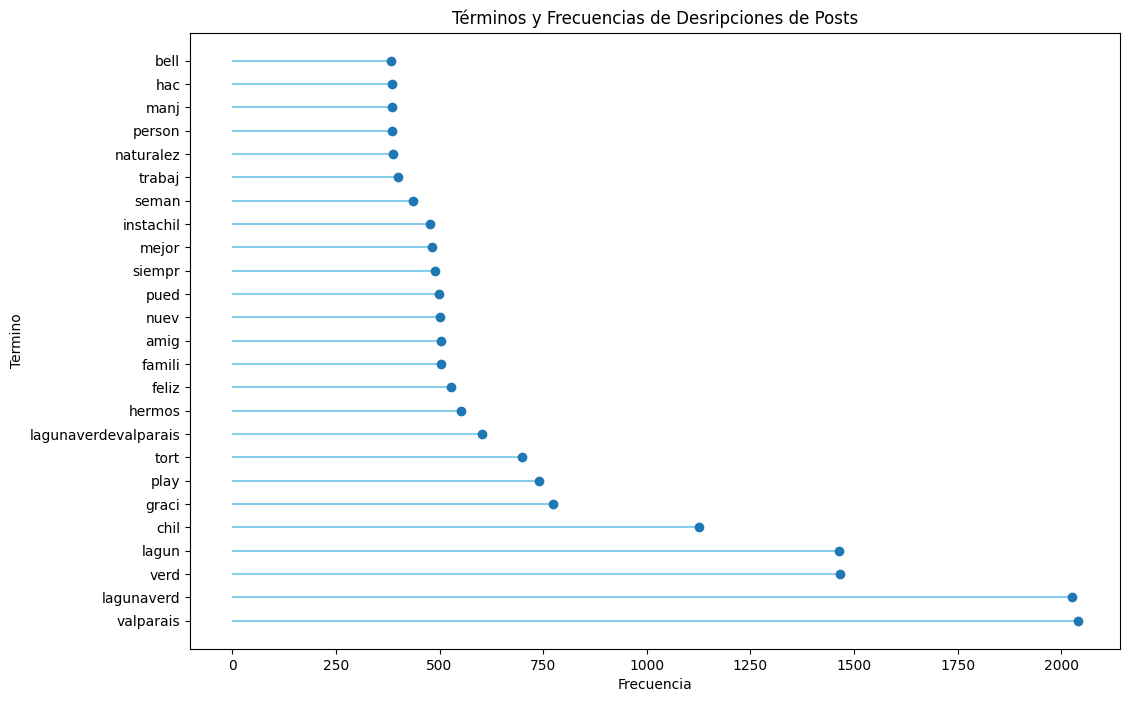

In [138]:
# Gráfico de frecuencias

rango=range(1,len(vocabulario.head(25).index)+1)
plt.figure(figsize = (12,8))
plt.hlines(y=rango, xmin=0, xmax=vocabulario['Frecuencia'].head(25), color='skyblue')
plt.plot(vocabulario['Frecuencia'].head(25), rango, "o")


plt.yticks(rango, vocabulario['Termino'].head(25))
plt.title("Términos y Frecuencias de Desripciones de Posts", loc='center')
plt.xlabel('Frecuencia')
plt.ylabel('Termino')

plt.show()

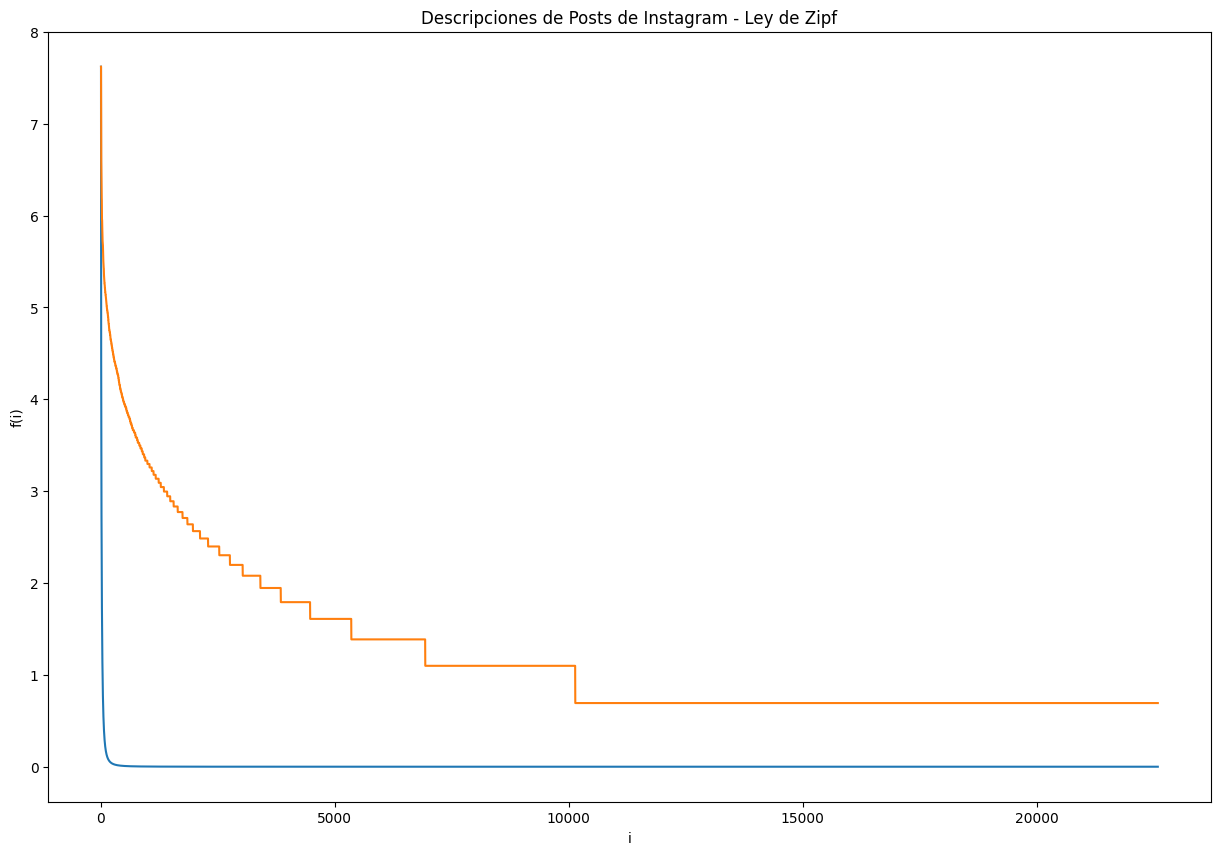

In [139]:
# Gráfico de Ley de Zipf

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(vocabulario.Ranking, np.log(vocabulario.Frecuencia_estimada+1));
ax.plot(vocabulario.Ranking, np.log(vocabulario.Frecuencia+1));

plt.title('Descripciones de Posts de Instagram - Ley de Zipf')
plt.xlabel("i")
plt.ylabel("f(i)")
plt.show()

In [140]:
# Ley de Heaps

total_oracion = pd.DataFrame(doc_term.groupby(['N_descripcion'])['Termino'].count())
total_oracion = total_oracion.rename(columns={'Termino':'Terminos_totales'})

distint_oracion = pd.DataFrame(doc_term.groupby(['N_descripcion'])['Termino'].nunique())
distint_oracion = distint_oracion.rename(columns={'Termino':'Terminos_distintos'})

vocabulario_oracion = pd.concat([total_oracion,distint_oracion], axis=1).sort_values(by='Terminos_distintos', ascending=True).reset_index()


In [141]:
vocabulario_oracion

,N_descripcion,Terminos_totales,Terminos_distintos
0,11190,0,0
1,9333,0,0
2,3494,0,0
3,9342,0,0
4,3485,0,0
...,...,...,...
13042,2716,156,130
13043,7104,146,132
13044,472,166,133
13045,995,163,134


In [142]:
# Parámetros arbitrarios par la Ley de Heaps

K=30
beta=0.8

vocabulario_oracion['V']=K*(vocabulario_oracion.Terminos_totales**beta)
vocabulario_oracion

,N_descripcion,Terminos_totales,Terminos_distintos,V
0,11190,0,0,0.000000
1,9333,0,0,0.000000
2,3494,0,0,0.000000
3,9342,0,0,0.000000
4,3485,0,0,0.000000
...,...,...,...,...
13042,2716,156,130,1704.593914
13043,7104,146,132,1616.603592
13044,472,166,133,1791.462514
13045,995,163,134,1765.514701


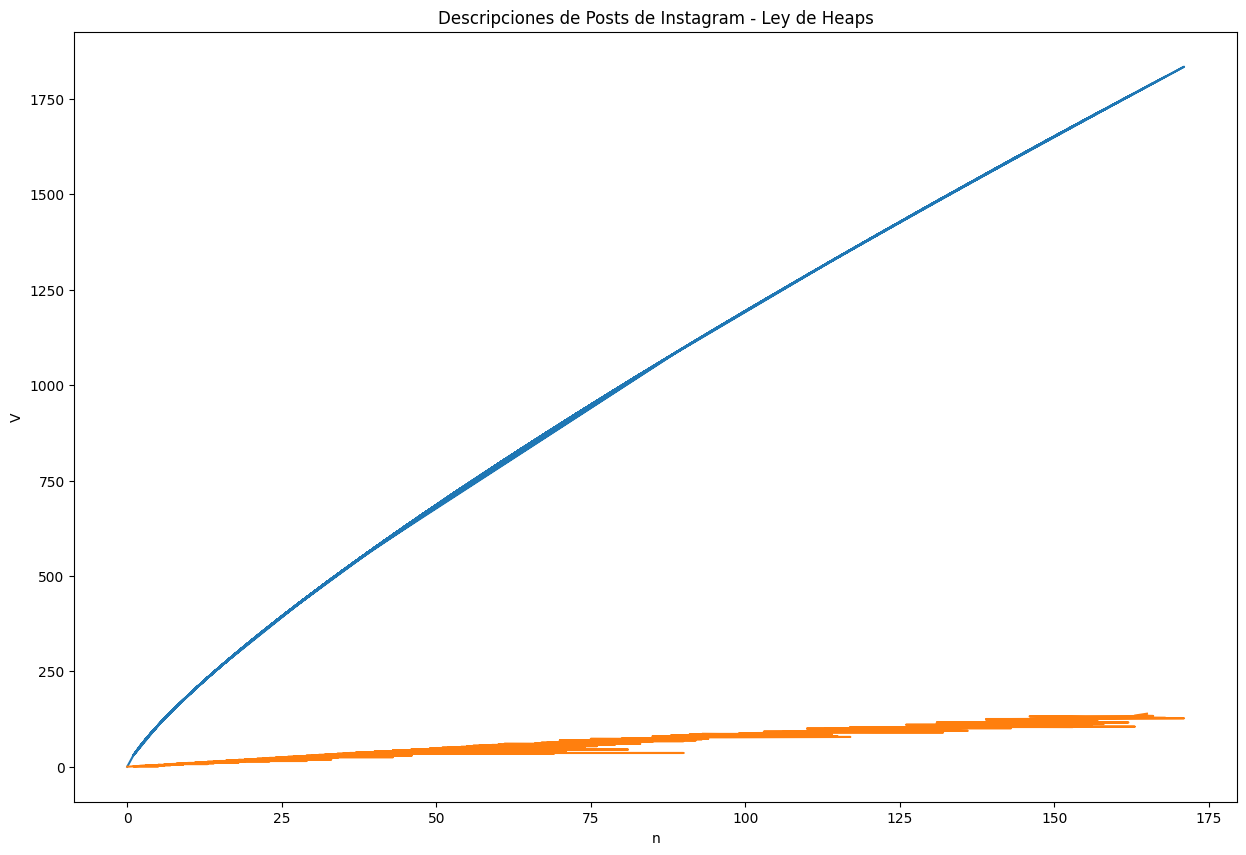

In [143]:
# Gráfico de Ley de Heaps

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(vocabulario_oracion.Terminos_totales, vocabulario_oracion.V)
ax.plot(vocabulario_oracion.Terminos_totales, vocabulario_oracion.Terminos_distintos)


plt.title('Descripciones de Posts de Instagram - Ley de Heaps')
plt.xlabel("n")
plt.ylabel("V")

plt.show()

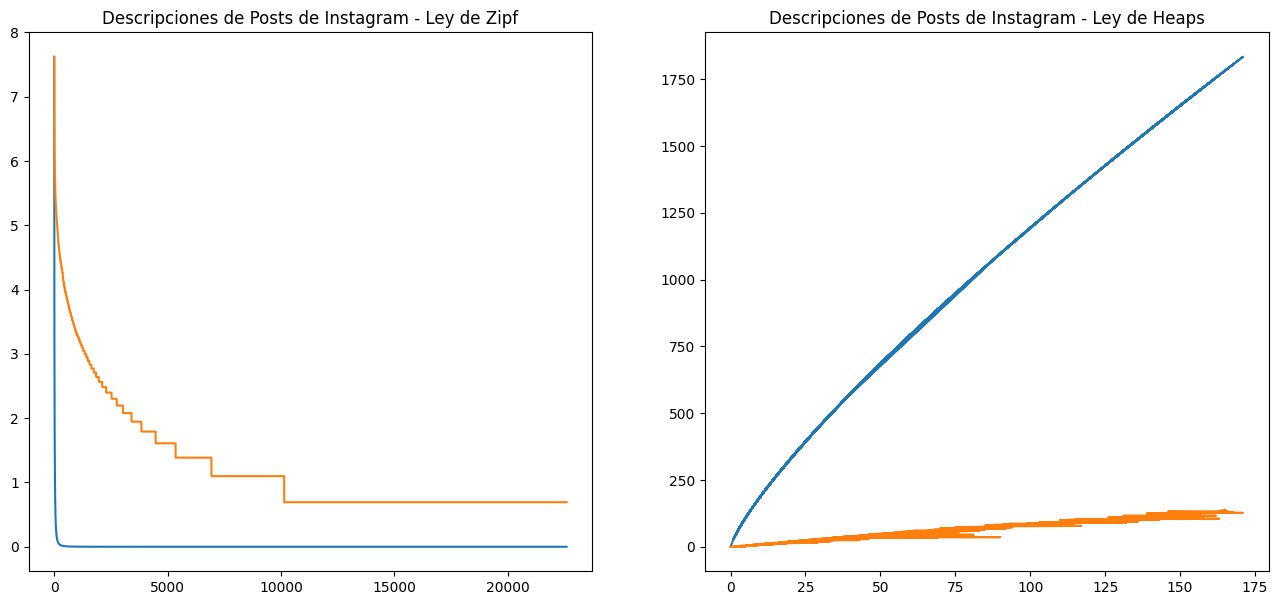

In [144]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

fig.set_size_inches(16, 7)

ax1.plot(vocabulario.Ranking, np.log(vocabulario.Frecuencia_estimada+1))
ax1.plot(vocabulario.Ranking, np.log(vocabulario.Frecuencia+1))

ax2.plot(vocabulario_oracion.Terminos_totales, vocabulario_oracion.V)
ax2.plot(vocabulario_oracion.Terminos_totales, vocabulario_oracion.Terminos_distintos)

ax1.set_title('Descripciones de Posts de Instagram - Ley de Zipf')
ax2.set_title('Descripciones de Posts de Instagram - Ley de Heaps')

plt.show()

A partir del gráfico de la Ley de Zipf se estaría observando que el texto no tendría mucha "riqueza" en sus términos, habiendo una distribución "escalonada" que indicaría una distribución muy alejada respecto a la estimada.

En cuanto a la ley de Heaps se estaría observando también la presencia de una distribución que no permitiría una mayor profunidad de análisis o modelamiento, lo que se evidencia en la falta de concavidad en la curva, y sería indicador de una alta presencia de escasez (*scarcity*) debido a una gran cantidad de filas con términos totales iguales a 1 o, en la segmentación del texto escogida, filas donde los términos serían 0 al haberse filtrado todos como *stopwords*.

# 12.2.3. Segmentación (Clusters)

In [145]:
# Matriz TF-IDF

# Se instancia el modelo para vectorizar

def identity_tokenizer(text):
    return text

tfidf_vect = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False,
                             use_idf=True,
                             ngram_range=(1,1))

tfidf_vect.fit(df_descripcion.Contenido_limpio)
tfidf_data = tfidf_vect.transform(df_descripcion.Contenido_limpio)

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [146]:
tfidf_df=pd.DataFrame(tfidf_data.toarray(), columns=tfidf_vect.get_feature_names())
tfidf_df.shape

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(13047, 22588)

In [147]:
tfidf_df.head(5)

,aaaaaanoh,aaaah,aagu,aaron,aartesanal,aatr,aavillanuev,abadon,abaj,abajoo,...,zumbawearcrew,zumbawearlov,zumbawearoriginal,zund,zunig,zurd,zwchil,zwe,zwearlov,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


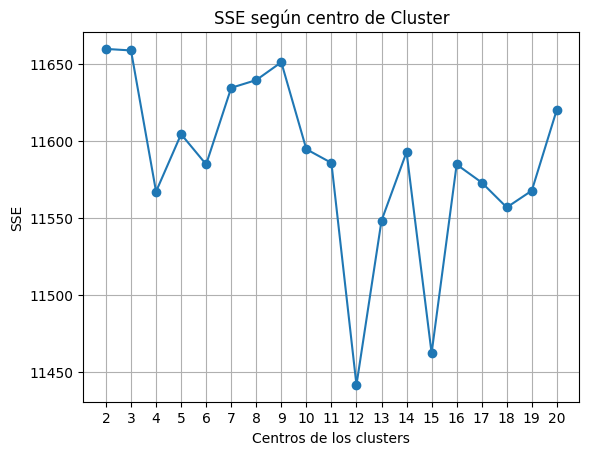

In [148]:
# Modelo de Clustering

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k,
                                   init_size=1024,
                                   batch_size=2048,
                                   random_state=20).fit(data).inertia_)
        print(f'Fit {k} clusters')
        
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Centros de los clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE según centro de Cluster')
    
    plt.grid()
    
find_optimal_clusters(tfidf_data, 20)

A partir de lo anterior se identifica que sería 7 el número ideal de clusters, identificándose que por sobre esa cantidad la segmentación empieza a verse muy afectada por la Suma Cuadrática de Errores (*SSE*)

In [149]:
clusters = MiniBatchKMeans(n_clusters=6,
                           init_size=1024,
                           batch_size=2048,
                           random_state=20).fit_predict(tfidf_data)

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sn

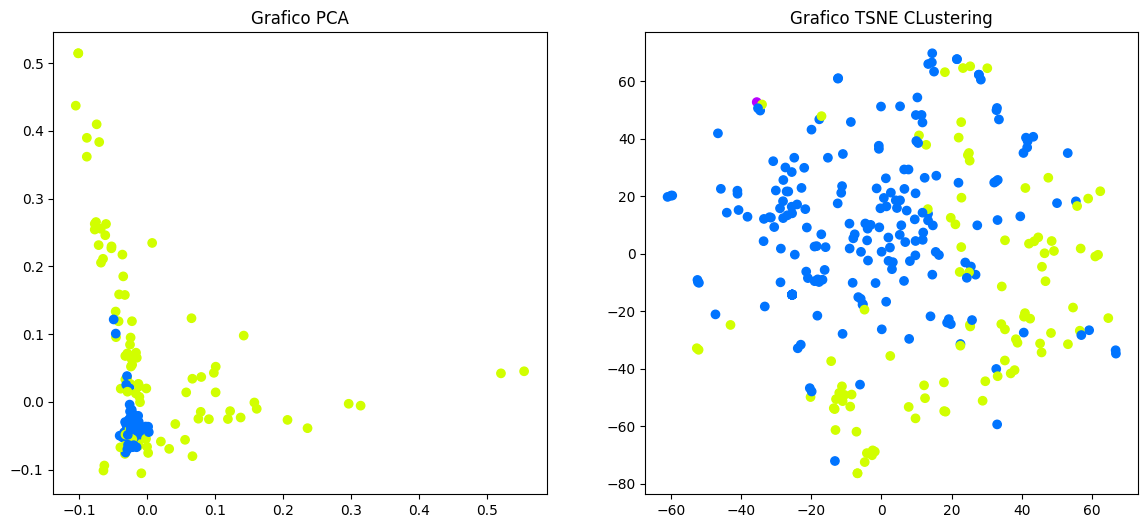

In [150]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('Grafico PCA')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('Grafico TSNE CLustering')
    
plot_tsne_pca(tfidf_data, clusters)

In [151]:
# Se busca obtener las palabras más frecuentes en cada cluster

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i+1))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            

get_top_keywords(tfidf_data, clusters, tfidf_vect.get_feature_names(), 20)


C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Cluster 1
espinoz,espinit,espazyart,espinill,espinak,espinac,espin,espesor,espes,esperenl,esperar,esperanz,espasm,nuev,dej,product,ten,perd,compart,lanzamient

Cluster 2
amig,bell,crem,chocolat,seman,celestesaborartesanal,vacacion,lind,lagunaverdevalparais,famili,hermos,manj,feliz,chil,tort,play,verd,valparais,lagun,lagunaverd

Cluster 3
espinak,amig,ped,cumplean,decoracion,tortatemat,celebracion,dobl,mixt,frambues,tortapin,tortachantilly,camar,lagunaverd,valparais,tortasclas,tort,negr,selv,tortaselvanegr

Cluster 4
gust,disfrut,junt,amig,hermos,trabaj,naturalez,felic,seman,esper,hac,pued,pas,acril,quier,buen,siempr,nuev,mejor,graci

Cluster 5
lagunaverd,chil,lagunaverdevalparais,natur,ultim,chic,extran,mirador,oton,play,nuev,buen,necesit,lind,disfrut,verd,bell,lagun,atardec,playit

Cluster 6
espiral,espinoz,espinit,espinill,esper,espinac,espinak,espesor,espes,esperenl,esperar,esperanz,esperancit,espin,zzzzzz,bell,cumplean,pase,princes,relaj


# 12.2.4. Polaridad

In [152]:
# Análisis de sentimientos
# # Se carga el léxico afin

path_lexicon = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTt3Ge6uQ2GwVGXTu35SGayN1Upxolwk9TNMpMJYr7V4FiQPnD1Tz1ofOSVkqiUruzCZR9cZP5X3Ied/pub?output=csv'

# lexicon=pd.read_csv('lexico_afinn.en.es.csv', sep=',', encoding='latin1')

lexicon = pd.read_csv(path_lexicon, sep=',', encoding='latin1')

In [153]:
lexicon

,Palabra,Puntuacion,Word;
0,a bordo,1,aboard;
1,abandona,-2,abandons;
2,abandonado,-2,abandoned;
3,abandonar,-2,abandon;
4,abatido,-2,dejected;
...,...,...,...
2471,wowww,4,wowww;
2472,wtf,-4,wtf;
2473,yeees,2,yeees;
2474,culpar,-2,blame;


In [154]:
# Se aplica una función que asigna un puntaje a cada documento

def sentimiento(cadena):
    # Se cargan los datos del léxico afin en listas
    lexis=' '.join(lexicon.Palabra)
    punct=list(lexicon.Puntuacion)
    
    # Se generan listas vacías
    palabra=[]
    puntaje=[]
    pu=[]
    
    # Se separa cada palabra del documento
    palabras=cadena.split()
    pfinal=np.nan
    
    # Se realiza una iteración sobre cada palabra del documento, calculando el puntaje
    for p in palabras:
        try:
            t=re.search(p,lexis).group()      
            palabra.append(t)
            pu=lexicon[lexicon['Palabra']==t]['Puntuacion'].mean()
            puntaje.append(pu)
            
        except AttributeError:
            continue
            
    # Se calcula la media
    pfinal=np.nanmean(puntaje)
    
    # Se genera un if-else ante casos donde hubieran NaN
    if np.isnan(pfinal)==True:
        pfinal=np.nan_to_num(pfinal)
    else:
        pfinal
    
    return(pfinal)     

In [155]:
# Se vuelve a generar la limpieza, pero esta vez sin lematización con el fin de poder
# observar los resultados con mayor contexto

def limpieza_sin_lematizacion(texto):
    # Transformaciones realizadas:
    
    texto_norm=texto.lower() # conversión a minúsculas
    texto_norm=texto_norm.strip() # eliminación de espacios iniciales y finales
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = unicodedata.normalize('NFD', texto_norm).encode('ascii', 'ignore').decode("utf-8") # conversión de codificación de texto
    texto_norm=re.sub('[^A-Za-z]+', ' ', texto_norm) # se mantienen caracteres alfanuméricos
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = word_tokenize(texto_norm) # tokenización del texto

    # texto_norm = [token for token in texto_norm if len(token) > X] # eliminación de textos de largo menor a X

    texto_norm = [token for token in texto_norm if len(token) > 4] # eliminación de textos de largo menor a 4

    
    texto_norm = [word for word in texto_norm if not word in stop_words] # eliminación de stopwords
    
    return(texto_norm)

In [156]:
# df_decripcion
# df_decripcion_sentimientos

df_descripcion_sentimientos = df_descripcion.copy()

df_descripcion_sentimientos = df_descripcion_sentimientos.drop(columns=['Contenido_limpio'])

df_descripcion_sentimientos['Contenido_limpio'] = df_descripcion_sentimientos['Contenido_crudo'].apply(lambda x: limpieza_sin_lematizacion(x))

In [157]:
df_descripcion_sentimientos['Contenido_limpio_detok'] = df_descripcion_sentimientos['Contenido_limpio'].map(lambda x: detok.detokenize(x))

In [158]:
df_descripcion_sentimientos.head()

,ImageID,User,Contenido_crudo,URL,Contenido_limpio_detok,N_descripcion,Contenido_limpio
230,231,microparticulasdeluz,Manta raya enséñame más Tu habilidad de nadar...,https://www.instagram.com/p/BqVUOfandTe/,manta ensename habilidad nadar espejo refleja ...,1,"[manta, ensename, habilidad, nadar, espejo, re..."
231,232,antoniolanreb,"Estoy muy feliz que el Verano comenzó ?????,...",https://www.instagram.com/p/BqWHbutDfPL/,feliz verano comenzo olvide melvin happy becau...,2,"[feliz, verano, comenzo, olvide, melvin, happy..."
232,233,one_skl,Y nos prendemos en llamas y tu gatiando en mi ...,https://www.instagram.com/p/BqX8BR9BuKo/,prendemos llamas gatiando fotografo jajaja,3,"[prendemos, llamas, gatiando, fotografo, jajaja]"
233,234,sebatorrico,#artdirector Pronto estrenamos nuevo videocli...,https://www.instagram.com/p/BqzixXTH66h/,artdirector pronto estrenamos nuevo videoclip ...,4,"[artdirector, pronto, estrenamos, nuevo, video..."
234,235,banquetesyflores,Matrimonio #JPyAndrea Www.banquetesyflores.cl...,https://www.instagram.com/p/Bq0TINjHyAf/,matrimonio jpyandrea banquetesyflores matrimon...,5,"[matrimonio, jpyandrea, banquetesyflores, matr..."


In [159]:
df_descripcion_sentimientos['Polaridad'] = df_descripcion_sentimientos['Contenido_limpio_detok'].apply(lambda x: sentimiento(x))

C:\Users\Martín\AppData\Local\Temp\ipykernel_8380\1123528844.py:29: RuntimeWarning: Mean of empty slice
  pfinal=np.nanmean(puntaje)


In [160]:
display(df_descripcion_sentimientos.Polaridad.describe())

count    13047.000000
mean         0.422450
std          1.107458
min         -5.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: Polaridad, dtype: float64

<AxesSubplot:>

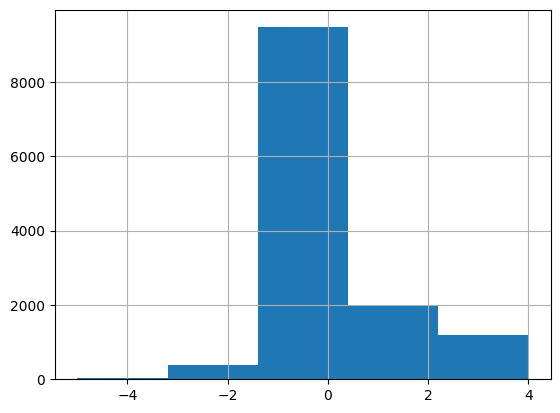

In [161]:
df_descripcion_sentimientos.Polaridad.hist(bins=5)

En esta instancia se observaría que, exceptuando los casos "neutros" (aquellos donde o no se dijo nada asignable a una polaridad negativa/positiva o donde el léxico afin no fue capaz de detectarla) habría una tendencia más cargada hacia lo positivo, lo que se interpreta como algo coherente dentro de lo visto hasta el momento, donde se detecta un contenido cargado hacia el enaltecimiento del lugar.

In [162]:
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer,
                      ngram_range=(1,3),
                      lowercase=False,
                      max_features=500,
                      binary=True,
                      use_idf=False,
                     norm = None)

tfidf.fit(df_descripcion_sentimientos.Contenido_limpio)

tfidf_data = tfidf.transform(df_descripcion_sentimientos.Contenido_limpio)

tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns=tfidf.get_feature_names())

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [163]:
tfidf_df.head()

,aceitecuticulas,acrilicas,acrilicas esculpidas,ademas,agendar,agradecida,ahora,alguien,alguna,amamos,...,vienen,viento,viernes,vinadelmar,visita,vista,vivir,volver,vregion,whatsapp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
# Se confirma que ambas tengan el mismo tamaño (cantidad de filas)

print(len(tfidf_df))
print(len(df_descripcion_sentimientos))

13047
13047


In [165]:
# Se preparan datos para el modelamiento

# Variable dependiente
mean=df_descripcion_sentimientos.Polaridad.mean()
std=df_descripcion_sentimientos.Polaridad.std()

label=(df_descripcion_sentimientos[['Polaridad']].astype(float)-mean)/std

# Variable independiente
features=tfidf_df

In [166]:
label

,Polaridad
230,-0.381460
231,2.327448
232,2.327448
233,-0.381460
234,-0.381460
...,...
34749,-1.510171
34750,-0.381460
34751,-0.983439
34752,-0.381460


In [167]:
# Segmentación de muestras para train test

features_train, features_test, label_train, label_test = sklearn.model_selection.train_test_split( 
    features,
    label,
    test_size=0.3, 
    random_state = 11
)

In [168]:
# Se instancia regresión lineal

lr = sklearn.linear_model.LinearRegression()
lr.fit(features_train, label_train)

LinearRegression()

In [169]:
# Se generan predicciones

lr_predictions = lr.predict(features_test)

In [170]:
# Se define una función para calcular el MAE (Mean Absolute Error)

def mae(true, predicted):
    error = true-predicted
    absolute_error = np.abs(error)
    return absolute_error.mean()

In [171]:
mae(label_test,lr_predictions)

Polaridad    9.722082e+08
dtype: float64

In [172]:
# Se define función para el RMSE (Root Mean Squared Error)

def rmse(true, predicted):
    error = true-predicted
    squared_error = error**2
    return (squared_error.mean())**0.5

In [173]:
rmse(label_test,lr_predictions)

Polaridad    3.594168e+10
dtype: float64

In [174]:
def regression_report(y_true, y_pred):
    return {
        'mae': sklearn.metrics.mean_absolute_error(y_true, y_pred),
        'rmse': sklearn.metrics.mean_squared_error(y_true, y_pred)
    }

In [175]:
lr_regression_report = regression_report(label_test, lr_predictions)
lr_regression_report

{'mae': 972208210.7131208, 'rmse': 1.29180455919638e+21}

In [176]:
# Se obtienen coeficientes de regresión

coefs_score=pd.DataFrame(list(lr.coef_)).T

coefs_score=coefs_score.rename(columns={coefs_score.columns[0]: 'Beta'})
var_tab=pd.DataFrame(features.columns)
var_tab=var_tab.rename(columns={var_tab.columns[0]: 'Var'})
coef_tab=pd.concat([var_tab, coefs_score], axis=1)
coef_tab=coef_tab.sort_values(by=['Beta'], ascending=False).reset_index()
# coef_tab.head(25)

In [177]:
# Los 20 términos positivos más importantes

print(coef_tab.head(15))

    index                                 Var          Beta
0      49     carabineros concesionaria conaf  2.594841e+13
1     433  taregion carabineros concesionaria  8.272508e+12
2     358        placilladepenuelas munivalpo  5.221105e+12
3     359  placilladepenuelas munivalpo esval  5.090859e+12
4      34                      bomberos onemi  5.065722e+12
5     292                     munivalpo esval  4.480241e+12
6     473             valparaiso laguna verde  1.073636e+12
7     432                taregion carabineros  9.488995e+11
8     297        nacional emergencia taregion  5.220758e+11
9     119                 emergencia taregion  3.461799e+11
10    326           onemi nacional emergencia  1.569191e+11
11    487                    verde valparaiso  1.853740e+00
12    153                               feliz  1.689825e+00
13    152                           felicidad  1.688924e+00
14    267                         maravilloso  1.636219e+00


In [178]:
coef_tab.head(15)

,index,Var,Beta
0,49,carabineros concesionaria conaf,2.594841e+13
1,433,taregion carabineros concesionaria,8.272508e+12
2,358,placilladepenuelas munivalpo,5.221105e+12
3,359,placilladepenuelas munivalpo esval,5.090859e+12
4,34,bomberos onemi,5.065722e+12
5,292,munivalpo esval,4.480241e+12
6,473,valparaiso laguna verde,1.073636e+12
7,432,taregion carabineros,9.488995e+11
8,297,nacional emergencia taregion,5.220758e+11
9,119,emergencia taregion,3.461799e+11


In [179]:
# Los 20 términos negativos más importantes

print(coef_tab.tail(20))

     index                                     Var          Beta
480    155                                   final -6.938708e-01
481    172                            frutos rojos -7.223364e-01
482    335                                  pasado -8.191232e-01
483    118                              emergencia -1.179112e+00
484     81                           concesionaria -1.180029e+00
485    437                                  tiempo -1.322888e+00
486    223                 laguna verde valparaiso -2.033366e+00
487    296                     nacional emergencia -7.611324e+11
488    472                       valparaiso laguna -1.073636e+12
489     35                 bomberos onemi nacional -1.462524e+12
490    325                          onemi nacional -2.208316e+12
491    120         emergencia taregion carabineros -2.607823e+12
492    293      munivalpo esval seguridadciudadana -2.899760e+12
493    408  seguridadciudadana incendiosforestales -3.183513e+12
494     82               

In [180]:
coef_tab.tail(15)

,index,Var,Beta
485,437,tiempo,-1.322888e+00
486,223,laguna verde valparaiso,-2.033366e+00
487,296,nacional emergencia,-7.611324e+11
488,472,valparaiso laguna,-1.073636e+12
489,35,bomberos onemi nacional,-1.462524e+12
490,325,onemi nacional,-2.208316e+12
491,120,emergencia taregion carabineros,-2.607823e+12
492,293,munivalpo esval seguridadciudadana,-2.899760e+12
493,408,seguridadciudadana incendiosforestales,-3.183513e+12
494,82,concesionaria conaf,-3.450092e+12


# 12.3. Análisis de hashtags de Posts

In [181]:
# Se eliminan las personas con demasiados hashtags

df_subconjunto_2 = df_subconjunto

# df_subconjunto_2 = df_subconjunto[df_subconjunto['N_Hashtags'] < upper_outer_fence]
# df_subconjunto_2 = df_subconjunto[df_subconjunto['N_Posts'] < upper_outer_fence]
# df_subconjunto_2 = df_subconjunto[df_subconjunto['N_Posts'] < upper_inner_fence]


# 12.3.1. Preprocesamiento

In [182]:
# Se vuelve a generar la limpieza, pero esta vez sin lematización con el fin de poder
# observar los resultados con mayor contexto

def limpieza_sin_lematizacion(texto):
    # Transformaciones realizadas:
    
    texto_norm=texto.lower() # conversión a minúsculas
    texto_norm=texto_norm.strip() # eliminación de espacios iniciales y finales
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = unicodedata.normalize('NFD', texto_norm).encode('ascii', 'ignore').decode("utf-8") # conversión de codificación de texto
    texto_norm=re.sub('[^A-Za-z]+', ' ', texto_norm) # se mantienen caracteres alfanuméricos
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = word_tokenize(texto_norm) # tokenización del texto

    # texto_norm = [token for token in texto_norm if len(token) > X] # eliminación de textos de largo menor a X

    # texto_norm = [token for token in texto_norm if len(token) > 4] # eliminación de textos de largo menor a 4
    
    texto_norm = [word for word in texto_norm if not word in stop_words] # eliminación de stopwords
    
    return(texto_norm)

In [183]:
# Lematizador

snowball = SnowballStemmer(language='spanish')

# Se define una función de limpieza

def limpieza(texto):
    # Transformaciones realizadas:
    
    texto_norm=texto.lower() # conversión a minúsculas
    texto_norm=texto_norm.strip() # eliminación de espacios iniciales y finales
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = unicodedata.normalize('NFD', texto_norm).encode('ascii', 'ignore').decode("utf-8") # conversión de codificación de texto
    texto_norm=re.sub('[^A-Za-z]+', ' ', texto_norm) # se mantienen caracteres alfanuméricos
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = word_tokenize(texto_norm) # tokenización del texto

    # texto_norm = [token for token in texto_norm if len(token) > X] # eliminación de textos de largo menor a X

    # texto_norm = [token for token in texto_norm if len(token) > 4] # eliminación de textos de largo menor a 4

    
    texto_norm = [word for word in texto_norm if not word in stop_words] # eliminación de stopwords
    
    # Lematización con stemmer de Snowball
    texto_norm=[snowball.stem(word) for word in texto_norm]
    
    return(texto_norm)

In [184]:
# df_subconjuntohashtags = df.copy()
# df_subconjuntohashtags = df_subconjuntohashtags[df_subconjuntohashtags['Date'] > fence_outer_low]
# df_subconjuntohashtags = df_subconjuntohashtags[df_subconjuntohashtags['N_Posts'] < upper_inner_fence]
# df_subconjunto = df_subconjunto.dropna(subset=['Hashtags'])
# df_subconjunto = df_subconjunto.drop_duplicates(subset=['URL'])

# df_decripcion = df_subconjunto[['ImageID', 'User', 'Hashtags']]
# df_decripcion = df_decripcion.rename(columns={"Hashtags" : "Contenido_crudo"})

# df_decripcion['Contenido_crudo'] = df_decripcion['Contenido_crudo'].astype(str)

In [185]:
# df_hashtags = df_subconjunto.copy()
df_hashtags = df_subconjunto_2.copy()

df_hashtags = df_hashtags.dropna(subset=['Hashtags'])
df_hashtags = df_hashtags[['ImageID', 'User', 'Hashtags', 'URL']]
df_hashtags = df_hashtags.rename(columns={"Hashtags" : "Contenido_crudo"})

In [186]:
# Convertir tuplas en listas

def tuplas_a_listas(tupla):
  return list(tupla)

# Aplicar la función a la columna de tuplas
df_hashtags['Contenido_crudo'] = df_hashtags['Contenido_crudo'].apply(tuplas_a_listas)

In [187]:
# Definir función para convertir listas a strings
def listas_a_strings(lista):
  return ' '.join(str(elemento) for elemento in lista)

# Aplicar la función a la columna de listas
df_hashtags['Contenido_crudo'] = df_hashtags['Contenido_crudo'].apply(listas_a_strings)

# Se confirma que los valores sean strings
df_hashtags['Contenido_crudo'] = df_hashtags['Contenido_crudo'].astype(str)

In [188]:
# df_hashtags['Contenido_limpio'] = df_hashtags['Contenido_crudo'].apply(lambda x: limpieza(x))
df_hashtags['Contenido_limpio'] = df_hashtags['Contenido_crudo'].apply(lambda x: limpieza_sin_lematizacion(x))


In [189]:
df_hashtags.head()

,ImageID,User,Contenido_crudo,URL,Contenido_limpio
230,231,microparticulasdeluz,photographer fotografosargentinos valparaiso v...,https://www.instagram.com/p/BqVUOfandTe/,"[photographer, fotografosargentinos, valparais..."
231,232,antoniolanreb,verano summer lagunaverdevalparaiso valparaiso...,https://www.instagram.com/p/BqWHbutDfPL/,"[verano, summer, lagunaverdevalparaiso, valpar..."
233,234,sebatorrico,artdirector luzjimenez,https://www.instagram.com/p/BqzixXTH66h/,"[artdirector, luzjimenez]"
234,235,banquetesyflores,JPyAndrea matrimonio campestre playa,https://www.instagram.com/p/Bq0TINjHyAf/,"[jpyandrea, matrimonio, campestre, playa]"
239,240,mickeyfiesta,juegoinflable productora eventos popcorn algod...,https://www.instagram.com/p/BrECrhAgzpJ/,"[juegoinflable, productora, eventos, popcorn, ..."


In [190]:
df_hashtags['Contenido_limpio'][230]

['photographer',
 'fotografosargentinos',
 'valparaiso',
 'valparaisochile',
 'chilegram',
 'chile',
 'lagunaverde',
 'lagunaverdevalparaiso',
 'beach',
 'beachhouse',
 'beachlife',
 'beachwaves',
 'beaches',
 'beachside',
 'beachwalk',
 'beachday',
 'dslr',
 'official',
 'instagramers',
 'instadaily',
 'followforfollowback',
 'follow',
 'followers',
 'loveislove',
 'lovequotes',
 'dslrcamera',
 'likelike',
 'dslrphotography',
 'canonphoto',
 'canonphotographers',
 'particulasdeluz']

In [191]:
print(type(df_hashtags['Contenido_limpio'][230]))

<class 'list'>


In [192]:
# Se genera una columna del contenido detokenizado

df_hashtags['Contenido_limpio_detok'] = df_hashtags['Contenido_limpio'].map(lambda x: detok.detokenize(x))

# Se genera una columna para identificar post

df_hashtags['N_hashtags'] = np.arange(len(df_hashtags)) + 1

In [193]:
df_hashtags.head()

,ImageID,User,Contenido_crudo,URL,Contenido_limpio,Contenido_limpio_detok,N_hashtags
230,231,microparticulasdeluz,photographer fotografosargentinos valparaiso v...,https://www.instagram.com/p/BqVUOfandTe/,"[photographer, fotografosargentinos, valparais...",photographer fotografosargentinos valparaiso v...,1
231,232,antoniolanreb,verano summer lagunaverdevalparaiso valparaiso...,https://www.instagram.com/p/BqWHbutDfPL/,"[verano, summer, lagunaverdevalparaiso, valpar...",verano summer lagunaverdevalparaiso valparaiso...,2
233,234,sebatorrico,artdirector luzjimenez,https://www.instagram.com/p/BqzixXTH66h/,"[artdirector, luzjimenez]",artdirector luzjimenez,3
234,235,banquetesyflores,JPyAndrea matrimonio campestre playa,https://www.instagram.com/p/Bq0TINjHyAf/,"[jpyandrea, matrimonio, campestre, playa]",jpyandrea matrimonio campestre playa,4
239,240,mickeyfiesta,juegoinflable productora eventos popcorn algod...,https://www.instagram.com/p/BrECrhAgzpJ/,"[juegoinflable, productora, eventos, popcorn, ...",juegoinflable productora eventos popcorn algod...,5


# 12.3.2. Ley de Zipf y Heaps

In [194]:
# Ley de Zipf

# Se genera un dataframe que intersecta cada término con cada oración
doc_term = df_hashtags.explode(column='Contenido_limpio')

# Se eliminan las columnas que no se ocupan y se renombra columna de términos
doc_term = doc_term.drop(columns=['Contenido_crudo'])
doc_term = doc_term.drop(columns=['Contenido_limpio_detok'])
doc_term = doc_term.rename(columns={'Contenido_limpio' : 'Termino'})

In [195]:
doc_term

,ImageID,User,URL,Termino,N_hashtags
230,231,microparticulasdeluz,https://www.instagram.com/p/BqVUOfandTe/,photographer,1
230,231,microparticulasdeluz,https://www.instagram.com/p/BqVUOfandTe/,fotografosargentinos,1
230,231,microparticulasdeluz,https://www.instagram.com/p/BqVUOfandTe/,valparaiso,1
230,231,microparticulasdeluz,https://www.instagram.com/p/BqVUOfandTe/,valparaisochile,1
230,231,microparticulasdeluz,https://www.instagram.com/p/BqVUOfandTe/,chilegram,1
...,...,...,...,...,...
34756,34757,k14ro_o,https://www.instagram.com/p/CkwYnoApyOg/,coquette,5512
34756,34757,k14ro_o,https://www.instagram.com/p/CkwYnoApyOg/,coquetteaesthetic,5512
34756,34757,k14ro_o,https://www.instagram.com/p/CkwYnoApyOg/,mar,5512
34756,34757,k14ro_o,https://www.instagram.com/p/CkwYnoApyOg/,playa,5512


In [196]:
# Se construye el vocabulario

vocabulario = doc_term.groupby(['Termino']).count().sort_values(by='N_hashtags', ascending=False).reset_index()
vocabulario = vocabulario.rename(columns={'N_hashtags':'Frecuencia'})

# Se determina el ranking según frecuencia

vocabulario['Ranking']=vocabulario.index+1

# Se agrega frecuencia estimada según fórmula de Ley de Zipf

vocabulario['Frecuencia_estimada']=vocabulario.Frecuencia[0]/(vocabulario.Ranking**2)

In [197]:
vocabulario.head()

,Termino,ImageID,User,URL,Frecuencia,Ranking,Frecuencia_estimada
0,lagunaverde,2005,2005,2005,2005,1,2005.000000
1,valparaiso,1594,1594,1594,1594,2,501.250000
2,chile,866,866,866,866,3,222.777778
3,lagunaverdevalparaiso,600,600,600,600,4,125.312500
4,instachile,454,454,454,454,5,80.200000


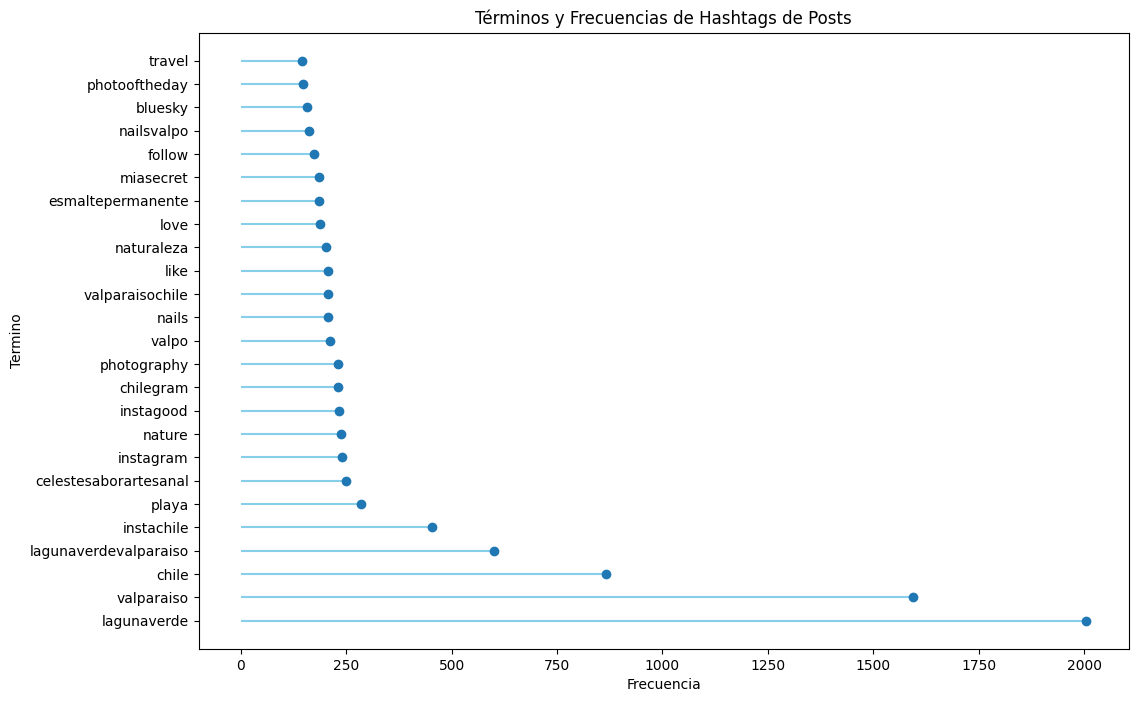

In [198]:
# Gráfico de frecuencias

rango=range(1,len(vocabulario.head(25).index)+1)
plt.figure(figsize = (12,8))
plt.hlines(y=rango, xmin=0, xmax=vocabulario['Frecuencia'].head(25), color='skyblue')
plt.plot(vocabulario['Frecuencia'].head(25), rango, "o")


plt.yticks(rango, vocabulario['Termino'].head(25))
plt.title("Términos y Frecuencias de Hashtags de Posts", loc='center')
plt.xlabel('Frecuencia')
plt.ylabel('Termino')

plt.show()

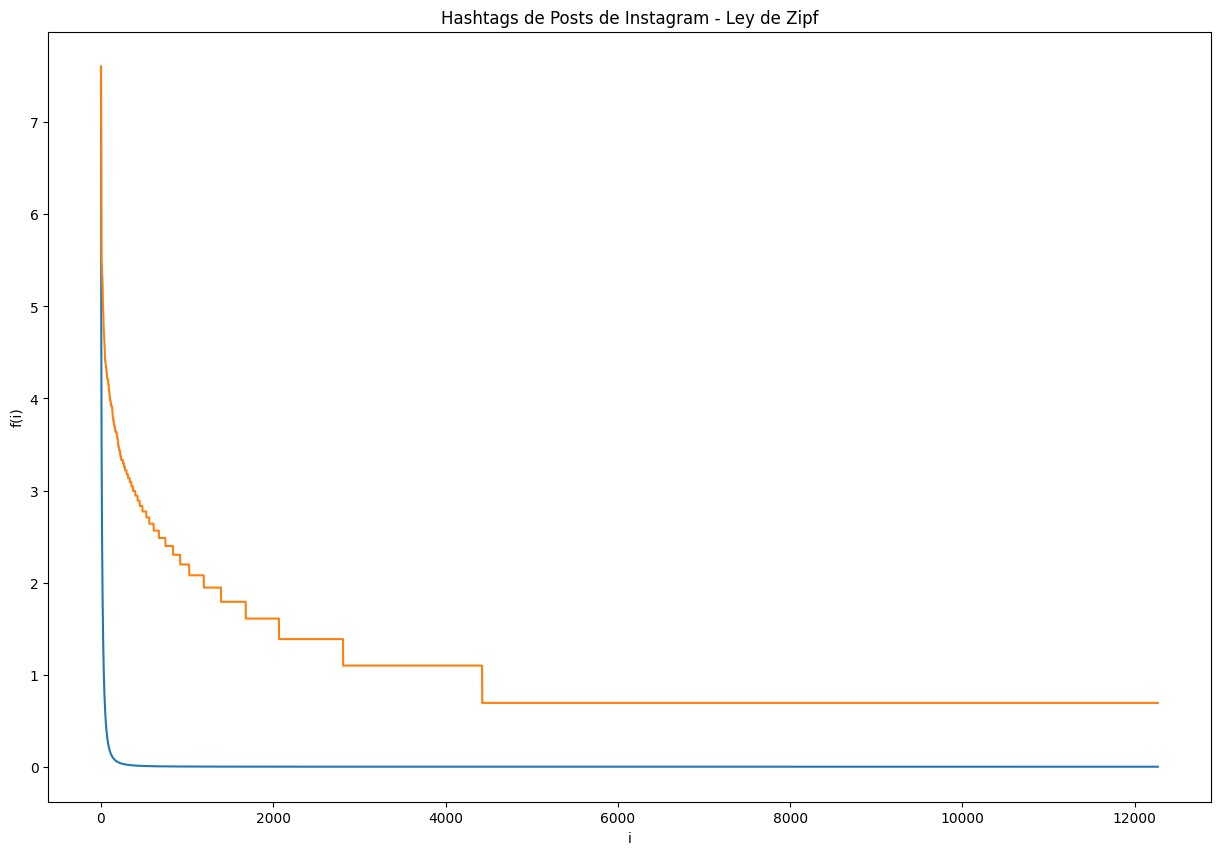

In [199]:
# Gráfico de Ley de Zipf

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(vocabulario.Ranking, np.log(vocabulario.Frecuencia_estimada+1));
ax.plot(vocabulario.Ranking, np.log(vocabulario.Frecuencia+1));

plt.title('Hashtags de Posts de Instagram - Ley de Zipf')
plt.xlabel("i")
plt.ylabel("f(i)")
plt.show()

In [200]:
# Se caracteriza cada oración según el número de palabras totales y el número de palabras distintas

total_oracion = pd.DataFrame(doc_term.groupby(['N_hashtags'])['Termino'].count())
total_oracion = total_oracion.rename(columns={'Termino':'Terminos_totales'})

distint_oracion = pd.DataFrame(doc_term.groupby(['N_hashtags'])['Termino'].nunique())
distint_oracion = distint_oracion.rename(columns={'Termino':'Terminos_distintos'})

vocabulario_oracion = pd.concat([total_oracion,distint_oracion], axis=1).sort_values(by='Terminos_distintos', ascending=True).reset_index()


In [201]:
vocabulario_oracion.head()

,N_hashtags,Terminos_totales,Terminos_distintos
0,5016,0,0
1,2634,0,0
2,2498,0,0
3,3063,1,1
4,3601,1,1


In [202]:
# Parámetros arbitrarios par la Ley de Heaps

# K=30
# beta=0.8

vocabulario_oracion['V']=K*(vocabulario_oracion.Terminos_totales**beta)

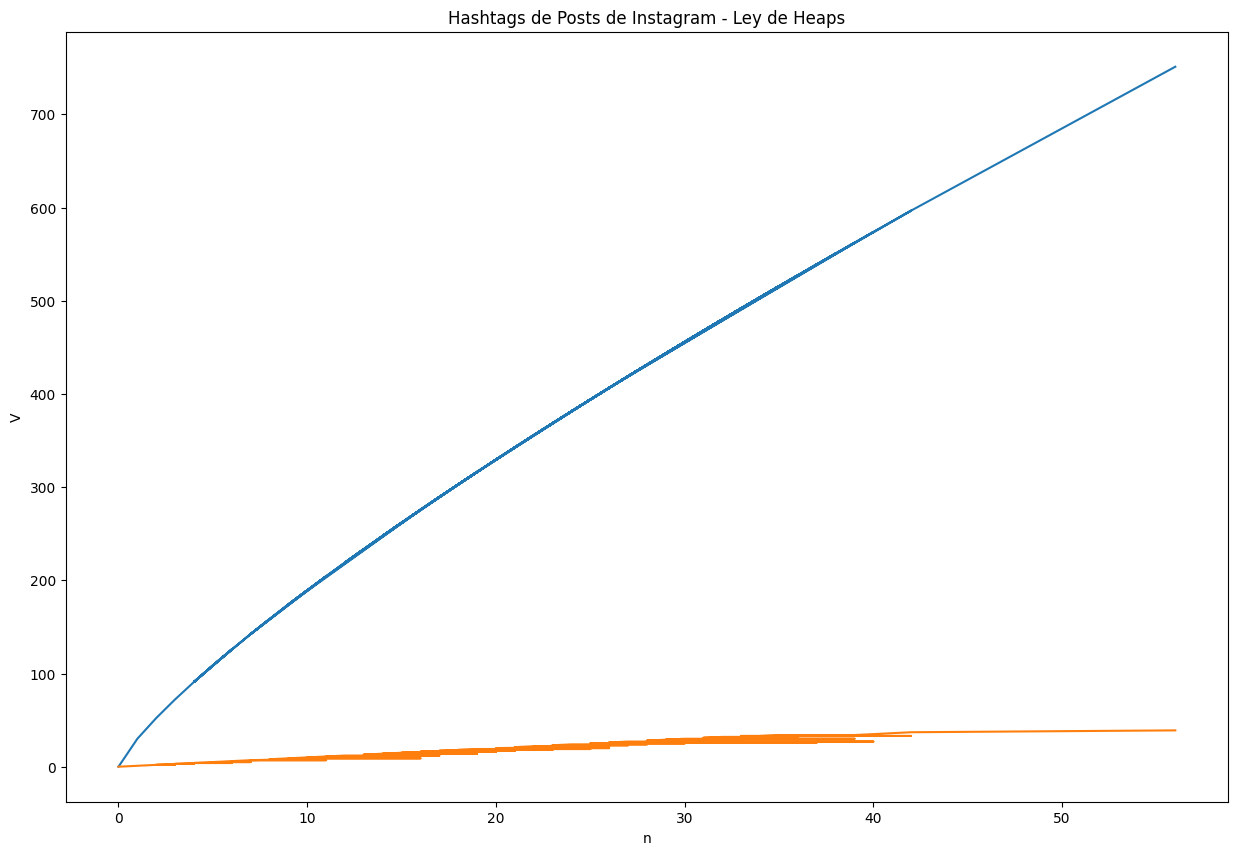

In [203]:
# Gráfico de Ley de Heaps

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(vocabulario_oracion.Terminos_totales, vocabulario_oracion.V)
ax.plot(vocabulario_oracion.Terminos_totales, vocabulario_oracion.Terminos_distintos)


plt.title('Hashtags de Posts de Instagram - Ley de Heaps')
plt.xlabel("n")
plt.ylabel("V")

plt.show()

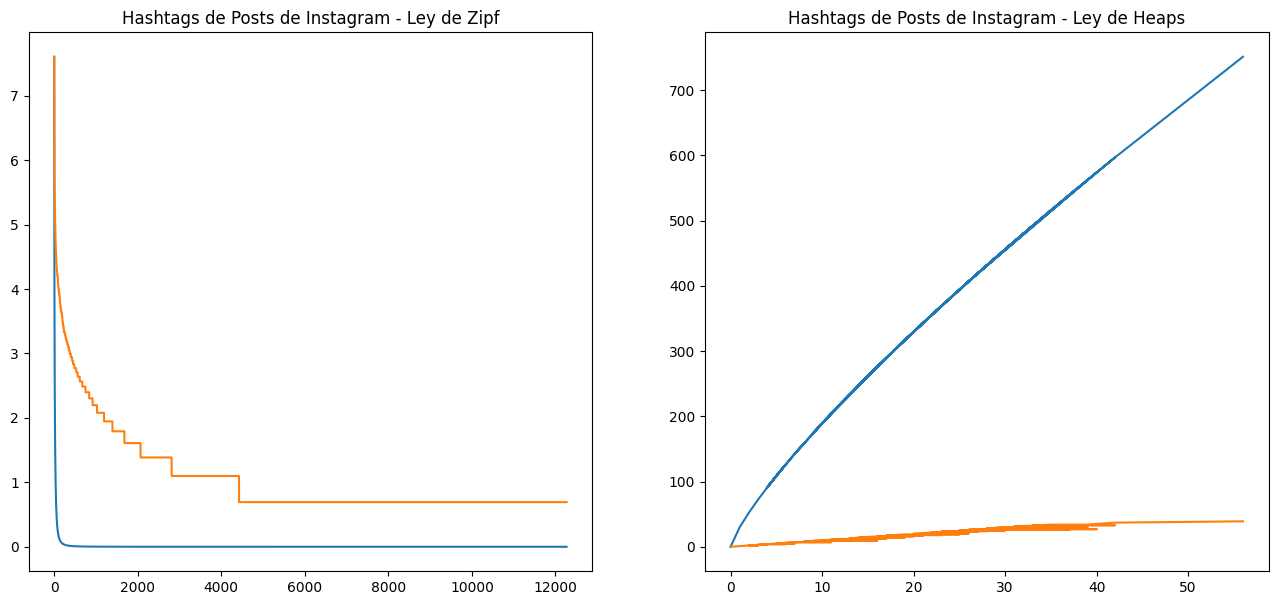

In [204]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

fig.set_size_inches(16, 7)

ax1.plot(vocabulario.Ranking, np.log(vocabulario.Frecuencia_estimada+1))
ax1.plot(vocabulario.Ranking, np.log(vocabulario.Frecuencia+1))

ax2.plot(vocabulario_oracion.Terminos_totales, vocabulario_oracion.V)
ax2.plot(vocabulario_oracion.Terminos_totales, vocabulario_oracion.Terminos_distintos)

ax1.set_title('Hashtags de Posts de Instagram - Ley de Zipf')
ax2.set_title('Hashtags de Posts de Instagram - Ley de Heaps')

plt.show()

# 12.3.3. Segmentación (Clusters)

In [205]:
# Matriz TF-IDF
# Se instancia el modelo para vectorizar

tfidf_vect = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False,
                             use_idf=True,
                             ngram_range=(1,1))

tfidf_vect.fit(df_hashtags.Contenido_limpio)
tfidf_data = tfidf_vect.transform(df_hashtags.Contenido_limpio)

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [206]:
tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns=tfidf_vect.get_feature_names())
tfidf_df.shape

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(5512, 12267)

In [207]:
tfidf_df.head(5)

,aaa,aartesanal,abandonados,abanicopink,abanicosfuego,abdulrazakgurnah,abejas,abejaschile,abenteuer,ablanca,...,zumbafitness,zumbainstructor,zumbalife,zumbalove,zumbatkm,zumbawear,zumbawearcrew,zumbawearlover,zumbawearoriginal,zwear
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


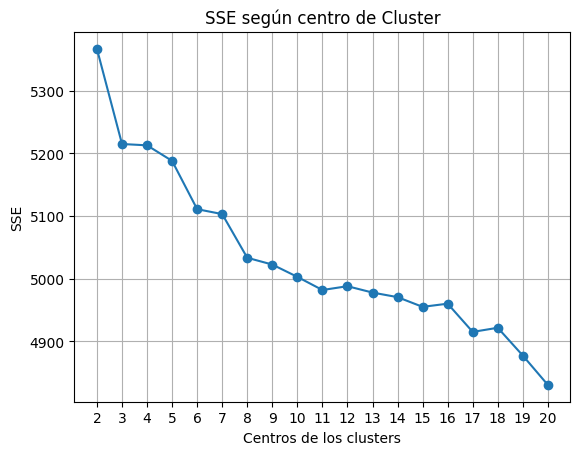

In [208]:
# def find_optimal_clusters(data, max_k):
#     iters = range(2, max_k+1, 1)
    
#     sse = []
#     for k in iters:
#         sse.append(MiniBatchKMeans(n_clusters=k,
#                                    init_size=1024,
#                                    batch_size=2048,
#                                    random_state=20).fit(data).inertia_)
#         print(f'Fit {k} clusters')
        
        
#     f, ax = plt.subplots(1, 1)
#     ax.plot(iters, sse, marker='o')
#     ax.set_xlabel('Centros de los clusters')
#     ax.set_xticks(iters)
#     ax.set_xticklabels(iters)
#     ax.set_ylabel('SSE')
#     ax.set_title('SSE según centro de Cluster')
    
#     plt.grid()
    
find_optimal_clusters(tfidf_data, 20)

In [209]:
clusters = MiniBatchKMeans(n_clusters=11,
                           init_size=1024,
                           batch_size=2048,
                           random_state=20).fit_predict(tfidf_data)

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sn

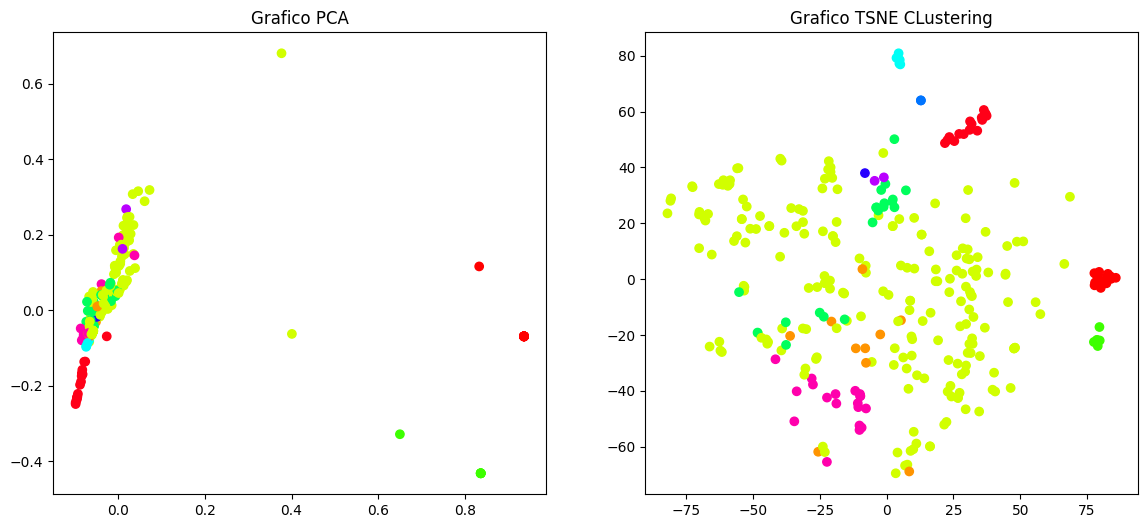

In [210]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('Grafico PCA')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('Grafico TSNE CLustering')
    
plot_tsne_pca(tfidf_data, clusters)

In [211]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i+1))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            

get_top_keywords(tfidf_data, clusters, tfidf_vect.get_feature_names(), 10)


C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Cluster 1
floresmoradas,floresnaturales,florespequenas,floressilvestres,florestattoo,florsilvestre,floreschile,valparaiso,lagunaverde,celestesaborartesanal

Cluster 2
foto,travel,naturaleza,photooftheday,naturephotography,photo,chile,fotografia,photography,nature

Cluster 3
valpo,tortas,familia,tortasclasicas,playa,placilla,chile,tortatematica,valparaiso,lagunaverde

Cluster 4
valparaiso,emprendimiento,home,primavera,diadelnino,chocolatecake,lagunaverde,pasteleriaartesanal,lagunaverdevalparaiso,celestesaborartesanal

Cluster 5
productos,valpo,playa,lagunaverdechile,valparaisochile,lagunaverde,trekking,valparaiso,chile,lagunaverdevalparaiso

Cluster 6
concesionaria,emergencia,munivalpo,onemi,conaf,taregion,bomberos,nacional,carabineros,samu

Cluster 7
cuidatupiel,totto,lorealparis,loquenecesitas,lomejor,hombres,valparaisochile,parati,mujeres,leonisa

Cluster 8
floressilvestres,florestattoo,florsilvestre,florescomestibles,chile,playa,lagunaverdechile,valparaiso,lagunaverde,lagunaverdeva

# 12.3.4. Polaridad

In [212]:
df_hashtags_sentimientos = df_hashtags.copy()

df_hashtags_sentimientos = df_hashtags_sentimientos.drop(columns=['Contenido_limpio'])

df_hashtags_sentimientos['Contenido_limpio'] = df_hashtags_sentimientos['Contenido_crudo'].apply(lambda x: limpieza_sin_lematizacion(x))
# df_hashtags_sentimientos['Contenido_limpio'] = df_hashtags_sentimientos['Contenido_crudo'].apply(lambda x: limpieza(x))


df_hashtags_sentimientos['Contenido_limpio_detok'] = df_hashtags_sentimientos['Contenido_limpio'].map(lambda x: detok.detokenize(x))

df_hashtags_sentimientos['Polaridad'] = df_hashtags_sentimientos['Contenido_limpio_detok'].apply(lambda x: sentimiento(x))

C:\Users\Martín\AppData\Local\Temp\ipykernel_8380\1123528844.py:29: RuntimeWarning: Mean of empty slice
  pfinal=np.nanmean(puntaje)


In [213]:
display(df_descripcion_sentimientos.Polaridad.describe())

count    13047.000000
mean         0.422450
std          1.107458
min         -5.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: Polaridad, dtype: float64

<AxesSubplot:>

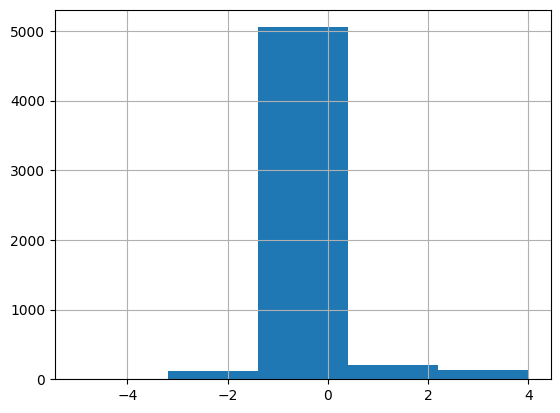

In [214]:
df_hashtags_sentimientos.Polaridad.hist(bins=5)

In [215]:
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer,
                    #   ngram_range=(3,3),
                      ngram_range=(1,3),
                      # ngram_range=(1,2),
                      # ngram_range=(2,2),
                      # ngram_range=(2,3),
                      
                      # ngram_range=(1,1),
                      # ngram_range=(1,4),
                      # ngram_range=(2,4),
                      
                      
                      
                      
                      lowercase=False,
                      max_features=500,
                      binary=True,
                      use_idf=False,
                     norm = None)

tfidf.fit(df_hashtags_sentimientos.Contenido_limpio)

tfidf_data = tfidf.transform(df_hashtags_sentimientos.Contenido_limpio)

tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns=tfidf.get_feature_names())

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [216]:
tfidf_df.head()

,abono,aceitecuticulas,aceitecuticulas miasecret,achilepoh,acrigel,adoptanocompres,altastemperaturas,altastemperaturas fuerteviento,altastemperaturas fuerteviento sequia,amigos,...,verde,viajes,vida,vina,vina quilpue,vina quilpue entregas,vinadelmar,vregion,woman,yoamoviajarporchile
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [217]:
# Se confirma que ambas tengan el mismo tamaño (cantidad de filas)

print(len(tfidf_df))
print(len(df_hashtags_sentimientos))

5512
5512


In [218]:
mean=df_hashtags_sentimientos.Polaridad.mean()
std=df_hashtags_sentimientos.Polaridad.std()

label=(df_hashtags_sentimientos[['Polaridad']].astype(float)-mean)/std

features=tfidf_df

In [219]:
label

,Polaridad
230,-0.131618
231,-0.131618
233,-0.131618
234,-0.131618
239,-0.131618
...,...
34744,-0.131618
34747,-0.131618
34749,-0.131618
34752,-0.131618


In [220]:
features_train, features_test, label_train, label_test = sklearn.model_selection.train_test_split( 
    features,
    label,
    test_size=0.3, 
    random_state = 11
)

In [221]:
lr = sklearn.linear_model.LinearRegression()
lr.fit(features_train, label_train)

LinearRegression()

In [222]:
# Se generan predicciones

lr_predictions = lr.predict(features_test)

In [223]:
mae(label_test,lr_predictions)

Polaridad    4.792236e+10
dtype: float64

In [224]:
rmse(label_test,lr_predictions)

Polaridad    9.976959e+11
dtype: float64

In [225]:
lr_regression_report = regression_report(label_test, lr_predictions)
lr_regression_report

{'mae': 47922362036.26797, 'rmse': 9.953971884989175e+23}

In [226]:
coefs_score=pd.DataFrame(list(lr.coef_)).T

coefs_score=coefs_score.rename(columns={coefs_score.columns[0]: 'Beta'})
var_tab=pd.DataFrame(features.columns)
var_tab=var_tab.rename(columns={var_tab.columns[0]: 'Var'})
coef_tab=pd.concat([var_tab, coefs_score], axis=1)
coef_tab=coef_tab.sort_values(by=['Beta'], ascending=False).reset_index()

In [227]:
# Los 20 términos positivos más importantes

print(coef_tab.head(15))

    index                                       Var          Beta
0      24                    bellezachile paraellas  4.191811e+13
1      25          bellezachile paraellas paraellos  4.019314e+13
2     241                           likes likesback  2.215163e+13
3      30                            bomberos onemi  1.364147e+13
4      56                                cbvm grimp  1.272198e+13
5      31                   bomberos onemi nacional  9.823779e+12
6       6                         altastemperaturas  8.460483e+12
7       7            altastemperaturas fuerteviento  7.688048e+12
8      37  bomberosquintay feuerwehrvalparaiso cbvm  7.313741e+12
9      35                           bomberosquintay  7.088282e+12
10     51                           cbsa bombasuiza  5.806201e+12
11     63                              chile parati  4.983456e+12
12     47                            carne pescados  4.137020e+12
13     48       carne pescados siguemeytesigoseguro  3.898703e+12
14      8 

In [228]:
coef_tab.head(15)

,index,Var,Beta
0,24,bellezachile paraellas,4.191811e+13
1,25,bellezachile paraellas paraellos,4.019314e+13
2,241,likes likesback,2.215163e+13
3,30,bomberos onemi,1.364147e+13
4,56,cbvm grimp,1.272198e+13
5,31,bomberos onemi nacional,9.823779e+12
6,6,altastemperaturas,8.460483e+12
7,7,altastemperaturas fuerteviento,7.688048e+12
8,37,bomberosquintay feuerwehrvalparaiso cbvm,7.313741e+12
9,35,bomberosquintay,7.088282e+12


In [229]:
# Los 20 términos negativos más importantes

print(coef_tab.tail(20))

     index                                          Var          Beta
480    173                        grimp cbsa bombasuiza -3.220531e+12
481    315                               onemi nacional -3.235434e+12
482    284                          nacional emergencia -3.246683e+12
483     54              cbv gasvalpo bomberoscasablanca -3.312022e+12
484    171                                        grimp -3.474270e+12
485    316                    onemi nacional emergencia -3.588824e+12
486    437                                 torta leches -3.769603e+12
487    110                          emergencia taregion -3.802805e+12
488    111                     emergencia taregion samu -3.999243e+12
489    285                 nacional emergencia taregion -4.109892e+12
490    317                            operacionesaereas -4.161266e+12
491    135                     feuerwehrvalparaiso cbvm -4.189940e+12
492    158  gasvalpo bomberoscasablanca bomberosquintay -4.219196e+12
493     45          

In [230]:
coef_tab.tail(15)

,index,Var,Beta
485,316,onemi nacional emergencia,-3.588824e+12
486,437,torta leches,-3.769603e+12
487,110,emergencia taregion,-3.802805e+12
488,111,emergencia taregion samu,-3.999243e+12
489,285,nacional emergencia taregion,-4.109892e+12
490,317,operacionesaereas,-4.161266e+12
491,135,feuerwehrvalparaiso cbvm,-4.189940e+12
492,158,gasvalpo bomberoscasablanca bomberosquintay,-4.219196e+12
493,45,carabineros concesionaria conaf,-4.655151e+12
494,172,grimp cbsa,-4.766092e+12


# Embeddings 2

In [231]:
df_embeddings = df_hashtags.copy()

In [232]:
df_embeddings = df_embeddings.reset_index()

In [233]:
df_embeddings.head()

,index,ImageID,User,Contenido_crudo,URL,Contenido_limpio,Contenido_limpio_detok,N_hashtags
0,230,231,microparticulasdeluz,photographer fotografosargentinos valparaiso v...,https://www.instagram.com/p/BqVUOfandTe/,"[photographer, fotografosargentinos, valparais...",photographer fotografosargentinos valparaiso v...,1
1,231,232,antoniolanreb,verano summer lagunaverdevalparaiso valparaiso...,https://www.instagram.com/p/BqWHbutDfPL/,"[verano, summer, lagunaverdevalparaiso, valpar...",verano summer lagunaverdevalparaiso valparaiso...,2
2,233,234,sebatorrico,artdirector luzjimenez,https://www.instagram.com/p/BqzixXTH66h/,"[artdirector, luzjimenez]",artdirector luzjimenez,3
3,234,235,banquetesyflores,JPyAndrea matrimonio campestre playa,https://www.instagram.com/p/Bq0TINjHyAf/,"[jpyandrea, matrimonio, campestre, playa]",jpyandrea matrimonio campestre playa,4
4,239,240,mickeyfiesta,juegoinflable productora eventos popcorn algod...,https://www.instagram.com/p/BrECrhAgzpJ/,"[juegoinflable, productora, eventos, popcorn, ...",juegoinflable productora eventos popcorn algod...,5


In [234]:
df_embeddings['Contenido_limpio'][1]

['verano', 'summer', 'lagunaverdevalparaiso', 'valparaiso', 'instachile']

In [235]:
type(df_embeddings['Contenido_limpio'][1])

list

In [236]:
#preprocesamiento minimo
def preprocess(text):
    # tokens = text.split(" ")
    tokens = text

    return [token for token in tokens if len(token) > 2]

In [237]:
sentences = list(map(preprocess, df_embeddings['Contenido_limpio']))

In [238]:
sentences = list(list(map(preprocess, df_embeddings['Contenido_limpio'])))

In [239]:
sentences

[['photographer',
  'fotografosargentinos',
  'valparaiso',
  'valparaisochile',
  'chilegram',
  'chile',
  'lagunaverde',
  'lagunaverdevalparaiso',
  'beach',
  'beachhouse',
  'beachlife',
  'beachwaves',
  'beaches',
  'beachside',
  'beachwalk',
  'beachday',
  'dslr',
  'official',
  'instagramers',
  'instadaily',
  'followforfollowback',
  'follow',
  'followers',
  'loveislove',
  'lovequotes',
  'dslrcamera',
  'likelike',
  'dslrphotography',
  'canonphoto',
  'canonphotographers',
  'particulasdeluz'],
 ['verano', 'summer', 'lagunaverdevalparaiso', 'valparaiso', 'instachile'],
 ['artdirector', 'luzjimenez'],
 ['jpyandrea', 'matrimonio', 'campestre', 'playa'],
 ['juegoinflable',
  'productora',
  'eventos',
  'popcorn',
  'algodondeazucar',
  'tatuajesparaninos',
  'fiestafluor',
  'valparaiso',
  'quillota',
  'curauma',
  'renaca',
  'concon',
  'mantagua',
  'escuelas',
  'graduacion',
  'bautizo',
  'celebracion'],
 ['donito', 'lagunaverde', 'valparaiso'],
 ['weird',
  

In [240]:
# sentences = list(map(df_embeddings['Contenido_limpio']))

In [241]:
#función para generar vocabulario
def get_vocabulary(corpus):
    vocabulary = []
    for text in corpus:
        vocabulary += text
    return sorted(list(set(vocabulary)))

In [242]:
#obtenemos vocabulario
vocabulary = get_vocabulary(sentences)

In [243]:
vocabulary

['aaa',
 'aartesanal',
 'abandonados',
 'abanicopink',
 'abanicosfuego',
 'abdulrazakgurnah',
 'abejas',
 'abejaschile',
 'abenteuer',
 'ablanca',
 'abono',
 'about',
 'abrazarnos',
 'abrazos',
 'abrigadita',
 'abril',
 'abroad',
 'abs',
 'abstractart',
 'abstracto',
 'abuelas',
 'abuelitalinda',
 'abuelo',
 'abuelos',
 'abundancia',
 'aburrido',
 'aca',
 'acab',
 'acabchile',
 'academia',
 'academiaua',
 'acambiarchile',
 'acampar',
 'acantilado',
 'acantilados',
 'acantiladosfedericosantamaria',
 'acaulis',
 'acccionpoetica',
 'accent',
 'accesorios',
 'accesorioschile',
 'accesoriosdemoda',
 'accesoriosvalparaiso',
 'accessorios',
 'accion',
 'acdc',
 'aceilicas',
 'aceite',
 'aceitecuticulas',
 'acelgas',
 'aceroinoxidable',
 'achilepoh',
 'achupalla',
 'acidohialuronico',
 'acidtechno',
 'aciudadana',
 'acolchados',
 'acompanada',
 'acrigel',
 'acrilic',
 'acrilicas',
 'acrilicasesculpidas',
 'acrilicasrsculpidas',
 'acrilicnails',
 'acrilico',
 'acrilicosobrelienzo',
 'acrygel',


In [244]:
# WINDOW_SIZE = 2
# en clases también se cambia por 1 al comienzo

WINDOW_SIZE = 1


data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence))]: 
            if neighbor != word:
                data.append((word, neighbor))

In [245]:
data


[('fotografosargentinos', 'photographer'),
 ('valparaiso', 'fotografosargentinos'),
 ('valparaisochile', 'valparaiso'),
 ('chilegram', 'valparaisochile'),
 ('chile', 'chilegram'),
 ('lagunaverde', 'chile'),
 ('lagunaverdevalparaiso', 'lagunaverde'),
 ('beach', 'lagunaverdevalparaiso'),
 ('beachhouse', 'beach'),
 ('beachlife', 'beachhouse'),
 ('beachwaves', 'beachlife'),
 ('beaches', 'beachwaves'),
 ('beachside', 'beaches'),
 ('beachwalk', 'beachside'),
 ('beachday', 'beachwalk'),
 ('dslr', 'beachday'),
 ('official', 'dslr'),
 ('instagramers', 'official'),
 ('instadaily', 'instagramers'),
 ('followforfollowback', 'instadaily'),
 ('follow', 'followforfollowback'),
 ('followers', 'follow'),
 ('loveislove', 'followers'),
 ('lovequotes', 'loveislove'),
 ('dslrcamera', 'lovequotes'),
 ('likelike', 'dslrcamera'),
 ('dslrphotography', 'likelike'),
 ('canonphoto', 'dslrphotography'),
 ('canonphotographers', 'canonphoto'),
 ('particulasdeluz', 'canonphotographers'),
 ('summer', 'verano'),
 ('lag

In [246]:
len(vocabulary)

12187

In [247]:
features = np.zeros((len(data),len(vocabulary)),dtype=np.float32)
labels = np.zeros((len(data),len(vocabulary)),dtype=np.float32)
for i,(feature,label) in enumerate(data):
    features[i,vocabulary.index(feature)] = 1
    labels[i,vocabulary.index(label)] = 1

In [248]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [249]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [250]:
class Word2Vec:
    def __init__(self, vocab_size=0, embedding_dim=2, epochs=10000):
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.epochs=epochs
        self.optimizer = tf.optimizers.SGD(learning_rate=0.1)
    
    def train(self, x_train=None, y_train=None):
        self.W1 = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_dim]))
        self.b1 = tf.Variable(tf.random.normal([self.embedding_dim])) #bias
        
        self.W2 = tf.Variable(tf.random.normal([self.embedding_dim, self.vocab_size]))
        self.b2 = tf.Variable(tf.random.normal([self.vocab_size]))
        
        for _ in range(self.epochs):
            with tf.GradientTape() as t:
                hidden_layer = tf.add(tf.matmul(x_train,self.W1),self.b1)
                output_layer = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, self.W2), self.b2))
                cross_entropy_loss = tf.reduce_mean(-tf.math.reduce_sum(y_train * tf.math.log(output_layer), axis=[1]))
 
            grads = t.gradient(cross_entropy_loss, [self.W1, self.b1, self.W2, self.b2])
            self.optimizer.apply_gradients(zip(grads,[self.W1, self.b1, self.W2, self.b2]))
            if(_ % 1000 == 0):
                print(cross_entropy_loss)

In [251]:
w2v = Word2Vec(vocab_size=len(vocabulary), epochs=10000)
w2v.train(features, labels)

tf.Tensor(11.3463335, shape=(), dtype=float32)
tf.Tensor(10.291252, shape=(), dtype=float32)
tf.Tensor(9.9066, shape=(), dtype=float32)
tf.Tensor(9.681624, shape=(), dtype=float32)
tf.Tensor(9.5119505, shape=(), dtype=float32)


: 

: 

# 12.3.5. Text Embeddings

In [ ]:
df_hashtags = df_subconjunto2.copy()l

In [ ]:
df_hashtags

In [ ]:
# df_nuevo = pd.DataFrame(df_original, columns = ['col1', 'col2', 'col3'])

In [ ]:
embeddings_hashtags = pd.DataFrame(df_hashtags, columns = ['ImageID', 'URL', 'Contenido_crudo'])
embeddings_hashtags

In [ ]:
embeddings_hashtags['Contenido_limpio'] = embeddings_hashtags['Contenido_crudo'].apply(lambda x: limpieza_sin_lematizacion(x))

In [ ]:
embeddings_hashtags['Contenido_limpio'] = embeddings_hashtags['Contenido_limpio'].astype(str)

In [ ]:
embeddings_hashtags['Contenido_limpio_listas'] = embeddings_hashtags['Contenido_limpio'].astype(str)

In [ ]:
embeddings_hashtags['Contenido_limpio_listas'] = embeddings_hashtags['Contenido_limpio_listas'].str.replace(' ', '')

In [ ]:
embeddings_hashtags['Contenido_limpio_listas'] = embeddings_hashtags['Contenido_limpio_listas'].str.replace('[', '')
embeddings_hashtags['Contenido_limpio_listas'] = embeddings_hashtags['Contenido_limpio_listas'].str.replace(']', '')

In [ ]:
# embeddings_hashtags['Contenido_limpio_listas'] = embeddings_hashtags['Contenido_limpio'].str.replace("", "")

In [ ]:
embeddings_hashtags

In [ ]:
lista = []

for indice, datos_fila in embeddings_hashtags['Contenido_limpio_listas'].iteritems():
  # lista.append(datos_fila)
  # lista.append(list(datos_fila))
  datos_fila = datos_fila.replace("'", "")
  # print(datos_fila)
  datos_fila = datos_fila.split(",")
  # print(datos_fila)

  lista.append(datos_fila)

  # fila = list(datos_fila)
  # print(fila)
  # lista = list(datos_fila)

In [ ]:
lista

In [ ]:
# for item in lista:
#   print(item)

In [ ]:
#función para generar vocabulario
def get_vocabulary(corpus):
    vocabulary = []
    for text in corpus:
        vocabulary += text
    return sorted(list(set(vocabulary)))

In [ ]:
sentences = lista

In [ ]:
#obtenemos vocabulario
vocabulary = get_vocabulary(sentences)

In [ ]:
vocabulary

In [ ]:
# WINDOW_SIZE = 2
# en clases también se cambia por 1 al comienzo

WINDOW_SIZE = 1


data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        # Acá se toma una ventana de -WINDOWS_SIZE, WINDOWS_SIZE para generar el skip gram. Dado que las 
        # frases son cortas, se utiliza min y max para tener cuidado con los límites de la frase. 
        # Además, el +1 en el límite superior es para considerar el índice de la propia palabra en cuestión 
        # (probar qué ocurre cuando se elimina dicho +1)
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence))]: 
            if neighbor != word:
                data.append((word, neighbor))

In [ ]:
#revisamos resultados
data

In [ ]:
features = np.zeros((len(data),len(vocabulary)),dtype=np.float32)
labels = np.zeros((len(data),len(vocabulary)),dtype=np.float32)
for i,(feature,label) in enumerate(data):
    features[i,vocabulary.index(feature)] = 1
    labels[i,vocabulary.index(label)] = 1

In [ ]:
features

In [ ]:
labels

In [ ]:
class Word2Vec:
    def __init__(self, vocab_size=0, embedding_dim=2, epochs=10000):
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.epochs=epochs
        self.optimizer = tf.optimizers.SGD(learning_rate=0.1)
    
    def train(self, x_train=None, y_train=None):
        self.W1 = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_dim]))
        self.b1 = tf.Variable(tf.random.normal([self.embedding_dim])) #bias
        
        self.W2 = tf.Variable(tf.random.normal([self.embedding_dim, self.vocab_size]))
        self.b2 = tf.Variable(tf.random.normal([self.vocab_size]))
        
        for _ in range(self.epochs):
            with tf.GradientTape() as t:
                hidden_layer = tf.add(tf.matmul(x_train,self.W1),self.b1)
                output_layer = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, self.W2), self.b2))
                cross_entropy_loss = tf.reduce_mean(-tf.math.reduce_sum(y_train * tf.math.log(output_layer), axis=[1]))
 
            grads = t.gradient(cross_entropy_loss, [self.W1, self.b1, self.W2, self.b2])
            self.optimizer.apply_gradients(zip(grads,[self.W1, self.b1, self.W2, self.b2]))
            if(_ % 1000 == 0):
                print(cross_entropy_loss)

In [ ]:
w2v = Word2Vec(vocab_size=len(vocabulary), epochs=10000)
w2v.train(features, labels)

In [ ]:
#grafico de palabras TRAIN 1
import plotly.express as px
px.scatter(x=w2v.W1[:,0],y=w2v.W1[:,1],text=vocabulary)


In [ ]:
# embeddings_hashtags['Contenido_limpio'].str.replace(' ', ',')

In [ ]:
# embeddings_hashtags = pd.DataFrame(df_hashtags, columns = ['Contenido_crudo'])

In [ ]:
# embeddings_hashtags['Contenido_limpio_listas'] = embeddings_hashtags['Contenido_limpio'].str.replace(' ', ',')

In [ ]:
# embeddings_hashtags['Contenido_limpio'].str.replace(' ', ',')

In [ ]:
# embeddings_hashtags

In [ ]:
# embeddings_hashtags = pd.DataFrame(embeddings_hashtags, columns = ['Contenido_limpio_listas'])

# embeddings_hashtags = pd.DataFrame(embeddings_hashtags, columns = ['Contenido_limpio'])

In [ ]:
# embeddings_hashtags

In [ ]:
# lista = []

# for indice in embeddings_hashtags['Contenido_limpio'].iteritems():
#   strings = indice[1].split(',')
#   lista.append(strings)

In [ ]:
# lista = [] for indice, datos_fila in embeddings_hashtags.iterrows(): lista.append(list(datos_fila))

In [ ]:
# lista = []
# for indice, datos_fila in embeddings_hashtags.iterrows():
#     lista.append(list(datos_fila))

In [ ]:
# lista

In [ ]:
# for listas in lista:
#     for strings in listas:
#         for string in strings:
#             string.split(',')

In [ ]:
# for listas in lista:
#     for strings in listas:
#         strings = strings.split(',')
        # print(strings)

In [ ]:
# lista = []
# for indice, datos_fila in embeddings_hashtags['Contenido_limpio'].iteritems():
#     lista.append(datos_fila)

In [ ]:
# sentences = lista 

In [ ]:
# sentences

In [ ]:
# sentences2 = []

# for sentence in sentences:
#     # print(sentence)
#     for strings in sentence:
#         # strings.split(',')
#         strings = strings.split(',')
#         sentences2.append(strings)
#         # print(strings)

In [ ]:
# sentences2

In [ ]:
#función para generar vocabulario
def get_vocabulary(corpus):
    vocabulary = []
    for text in corpus:
        vocabulary += text
    return sorted(list(set(vocabulary)))

In [ ]:
#obtenemos vocabulario
vocabulary = get_vocabulary(sentences2)

In [ ]:
vocabulary

In [ ]:
# WINDOW_SIZE = 2
# en clases también se cambia por 1 al comienzo

WINDOW_SIZE = 1


data = []
for sentence in sentences2:
    for idx, word in enumerate(sentence):
        # Acá se toma una ventana de -WINDOWS_SIZE, WINDOWS_SIZE para generar el skip gram. Dado que las 
        # frases son cortas, se utiliza min y max para tener cuidado con los límites de la frase. 
        # Además, el +1 en el límite superior es para considerar el índice de la propia palabra en cuestión 
        # (probar qué ocurre cuando se elimina dicho +1)
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence))]: 
            if neighbor != word:
                data.append((word, neighbor))

In [ ]:
#revisamos resultados
data

In [ ]:
len(vocabulary)

In [ ]:
features = np.zeros((len(data),len(vocabulary)),dtype=np.float32)
labels = np.zeros((len(data),len(vocabulary)),dtype=np.float32)
for i,(feature,label) in enumerate(data):
    features[i,vocabulary.index(feature)] = 1
    labels[i,vocabulary.index(label)] = 1

In [ ]:
features

In [ ]:
labels

In [ ]:
class Word2Vec:
    def __init__(self, vocab_size=0, embedding_dim=2, epochs=10000):
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.epochs=epochs
        self.optimizer = tf.optimizers.SGD(learning_rate=0.1)
    
    def train(self, x_train=None, y_train=None):
        self.W1 = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_dim]))
        self.b1 = tf.Variable(tf.random.normal([self.embedding_dim])) #bias
        
        self.W2 = tf.Variable(tf.random.normal([self.embedding_dim, self.vocab_size]))
        self.b2 = tf.Variable(tf.random.normal([self.vocab_size]))
        
        for _ in range(self.epochs):
            with tf.GradientTape() as t:
                hidden_layer = tf.add(tf.matmul(x_train,self.W1),self.b1)
                output_layer = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, self.W2), self.b2))
                cross_entropy_loss = tf.reduce_mean(-tf.math.reduce_sum(y_train * tf.math.log(output_layer), axis=[1]))
 
            grads = t.gradient(cross_entropy_loss, [self.W1, self.b1, self.W2, self.b2])
            self.optimizer.apply_gradients(zip(grads,[self.W1, self.b1, self.W2, self.b2]))
            if(_ % 1000 == 0):
                print(cross_entropy_loss)

In [ ]:
w2v = Word2Vec(vocab_size=len(vocabulary), epochs=10000)
w2v.train(features, labels)

In [ ]:
#grafico de palabras TRAIN 1
import plotly.express as px
px.scatter(x=w2v.W1[:,0],y=w2v.W1[:,1],text=vocabulary)


In [ ]:
#grafico de palabras TRAIN 2
import plotly.express as px
px.scatter(x=w2v.W1[:,0],y=w2v.W1[:,1],text=vocabulary)